In [51]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import time
from random import randrange
import pretty_midi
import torch.nn.init as init

In [52]:
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])

    return torch.cat((x, y2),1)

def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])

        return torch.cat((x, y2),1)

    else:
        print(x_shapes[2:])
        print(y_shapes[2:])


def sigmoid_cross_entropy_with_logits(inputs,labels):
    loss = nn.BCEWithLogitsLoss()
    output = loss(inputs, labels)
    return output



def reduce_mean(x):
    output = torch.mean(x,0, keepdim = False)
    output = torch.mean(output,-1, keepdim = False)
    return output


def reduce_mean_0(x):
    output = torch.mean(x,0, keepdim = False)
    return output


def l2_loss(x,y):
    loss_ = nn.MSELoss(reduction='sum')
    l2_loss_ = loss_(x, y)/2
    return l2_loss_


def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

def generate_and_save_images(model, epoch, z, prev):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    model.eval()
    #print(z.shape)
    #print(prev.shape)
    with torch.no_grad():
        bar = model(z, prev).detach().cpu().numpy().squeeze().transpose()

    plt.imshow(bar)
    plt.colorbar()
    plt.title('Piano Roll Visualization')
    plt.xlabel('time')
    plt.ylabel('Note (MIDI Number)')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    model.train()

def print_piano_roll(piano_roll):
    plt.imshow(piano_roll)
    plt.colorbar()
    plt.title('Piano Roll Visualization')
    plt.xlabel('time')
    plt.ylabel('Note (MIDI Number)')
    plt.show()


class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims

        self.T = nn.Parameter(torch.Tensor(in_features, out_features, kernel_dims))
        init.normal_(self.T, 0, 1)

    def forward(self, x):
        # x is NxA
        # T is AxBxC
        matrices = x.mm(self.T.view(self.in_features, -1))
        matrices = matrices.view(-1, self.out_features, self.kernel_dims)

        M = matrices.unsqueeze(0)  # 1xNxBxC
        M_T = M.permute(1, 0, 2, 3)  # Nx1xBxC
        norm = torch.abs(M - M_T).sum(3)  # NxNxB
        expnorm = torch.exp(-norm)
        o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance

        x = torch.cat([x, o_b], 1)
        return x

In [53]:
# custom layer for convolutions with batch normalization and lrelu activation
class ConvolutionLayer2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel, stride, padding):
        super(ConvolutionLayer2d, self).__init__()
        self.conv = nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias = False)
        self.batch_norm = nn.BatchNorm2d(channels_out)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace = False)
    
    def forward(self,x, normalize=True):
        x = self.conv(x)
        if normalize:
            x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x
    
    @property
    def weight(self):
        return self.conv.weight

    @property
    def bias(self):
        return self.conv.bias

# custom layer for transposed convolutions with batch normalization and relu activation
class ConvolutionTransposeLayer2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel, stride, padding):
        super(ConvolutionTransposeLayer2d, self).__init__()
        self.conv = nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias = False)
        self.batch_norm = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU(inplace = False)
    
    def forward(self, x, normalize=True, activation=None):
        x = self.conv(x)
        if normalize:
            x = self.batch_norm(x)

        # Apply custom activation if provided, otherwise use ReLU by default
        if activation is not None:
            x = activation(x)
        else:
            x = self.relu(x)
        return x
    
    @property
    def weight(self):
        return self.conv.weight

    @property
    def bias(self):
        return self.conv.bias

# linear layer with batch normalization and relu activation for generator
class LinearLayer(nn.Module):
    def __init__(self, linear_in, linear_out):
        super(LinearLayer, self).__init__()
        self.linear = nn.Linear(linear_in, linear_out)
        self.batch_norm = nn.BatchNorm1d(linear_out)
        self.relu =  nn.ReLU()
    
    def forward(self, x, normalize = True, activation = None):
        x = self.linear(x)

        if normalize:
            x = self.batch_norm(x)

        if activation is not None:
            x = activation(x)
        else:
            x = self.relu(x)
        return x
    
    @property
    def weight(self):
        return self.linear.weight

    @property
    def bias(self):
        return self.linear.bias
    
class LearnedMaskingLayer(nn.Module):
    def __init__(self, num_notes):
        super(LearnedMaskingLayer, self).__init__()
        self.fc = nn.Linear(num_notes, num_notes)  # A linear layer to transform activations
        self.sigmoid = nn.Sigmoid()  # Activation to produce values between 0 and 1

    def forward(self, x):
        # x shape: [batch_size, time_steps, num_notes]
        batch_size, _, time_steps, num_notes = x.size()

        # Reshape x for the linear layer
        x_reshaped = x.view(-1, num_notes)  # Shape: [batch_size * time_steps, num_notes]
        
        # Pass through the learned layer
        mask_logits = self.fc(x_reshaped)  # Shape: [batch_size * time_steps, num_notes]
        
        # Apply sigmoid to get values between 0 and 1
        mask = self.sigmoid(mask_logits).view(batch_size, time_steps, num_notes)  # Reshape back

        mask = mask.unsqueeze(1)  

        # Apply the mask to the original output
        output = x * mask  # Element-wise multiplication
        return output


In [54]:
class Generator(nn.Module):
    def __init__(self, nz=100, pitches=128):
        super(Generator,self).__init__()
        self.nz = nz
        self.pitches = pitches
        self.filters_number = 128
        self.filters_number_conditioner = 128
        self.transpose_filters_number = 256
        
        self.linear0 = LinearLayer(nz, 1024)
        self.linear1 = LinearLayer(1024,512)
        
        # Generator transposed convolutions layers
        self.hidden0 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(10,1), stride=2, padding=0)
        self.hidden1 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden2 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out= self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden3 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=1, kernel=(1,pitches), stride=(1,2), padding=0)
        
        # Conditioner convolution layers
        self.condition_hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=self.filters_number_conditioner, kernel=(1,128), stride=(1,2), padding=0)
        self.condition_hidden1 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden2 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden3 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(10,1), stride=2, padding=0)

        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, z, prev_x):
        batch_size = prev_x.shape[0]
        
        condition_hidden0 = self.condition_hidden0(prev_x, normalize = False)
        condition_hidden0 = self.dropout(condition_hidden0)

        condition_hidden1 = self.condition_hidden1(condition_hidden0)
        #condition_hidden1 = self.dropout(condition_hidden1)

        condition_hidden2 = self.condition_hidden2(condition_hidden1)
       # condition_hidden2 = self.dropout(condition_hidden2)

        condition_hidden3 = self.condition_hidden3(condition_hidden2)
        #condition_hidden3 = self.dropout(condition_hidden3)
        
        z = z.view(batch_size,-1)

       # Transform z to match the shape of h4
        #z_transformed = self.z_transform(z).view(batch_size, 128, 32, 1)  # Adjust shape to match h4
        
        h0 = self.linear0(z)
        h1 = self.linear1(h0)
        
        h1 = h1.view(batch_size, 128, 4, 1)
        h1 = conv_prev_concat(h1, condition_hidden3)

        h2 = self.hidden0(h1)
        h2 = conv_prev_concat(h2, condition_hidden2)
        
        h3 = self.hidden1(h2)
        h3 = conv_prev_concat(h3, condition_hidden1)
        
        h4 = self.hidden2(h3)#+z_transformed)
        h4 = conv_prev_concat(h4, condition_hidden0)
        
        x = self.hidden3(h4, normalize=False, activation=nn.Sigmoid())

        #x = self.learned_masking(x)

                
        return x
        
# discriminator
class Discriminator(nn.Module):

    def __init__(self, pitches=128):
        super(Discriminator,self).__init__()
        self.pitches = pitches
        self.linear_in = 1232
        self.minibatch_features = 64
        
        self.hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=32, kernel=(2,128), stride=2, padding=0)
        self.hidden1 = ConvolutionLayer2d(channels_in=32, channels_out=77, kernel=(2,1), stride=2, padding=0)
        #self.hidden2 = ConvolutionLayer2d(channels_in=24, channels_out=24, kernel=(2,1), stride=2, padding=0)
        self.linear = nn.Linear(self.linear_in, 1024)
        self.linear2 = nn.Linear(1024+self.minibatch_features,1)
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU()

        # Minibatch Discrimination layer
        self.minibatch_discrimination = MinibatchDiscrimination(1024, self.minibatch_features, kernel_dims=72)

       
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = self.hidden0(x)
        fm = h0
        h1 = self.hidden1(h0)
        #h2 = self.hidden2(h1)
        h1 = h1.view(batch_size,-1)
        l = self.linear(h1)
        l = self.lrelu(l)

        # Minibatch discrimination
        minibatch_features = self.minibatch_discrimination(l)

        # Concatenate original features with minibatch discrimination features
        #l = torch.cat([l, minibatch_features], dim=1)

        out = self.linear2(minibatch_features)
        out_sigmoid = self.sigmoid(out)
        return out_sigmoid, out, fm 

In [55]:
def train(netD, netG, optimizerG, optimizerD, data_loader, epochs, criterion, nz, n_g_train, lamda1, lamda2, device):

   
    netG.train()
    netD.train()

    netG.to(device)
    netD.to(device)

    
    G_losses = []
    D_losses = []

    fixed_prev = train_iter[67][0].unsqueeze(0).to(device)

    print_piano_roll(train_iter[67][0].numpy().squeeze().transpose()) 

    for epoch in range(epochs):
        for i, (X, X_prev) in enumerate(data_loader, 0):

            X = X.to(device)
            X_prev = X_prev.to(device)

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            optimizerD.zero_grad()
            batch_size = X.size(0)
            output_real, logits_real, fm = netD(X)
            fm_r = fm.clone()
            real_label = torch.ones_like(logits_real) * 0.9 
            errD_real = reduce_mean(criterion(logits_real,real_label))
            D_x = output_real.mean().item()
            
            ## Train with all-fake batch
            noise = torch.rand(batch_size, nz, device=device)
            fake = netG(noise,X_prev)
            output_fake, logits_fake, fm_ = netD(fake.detach())
            fake_label = torch.zeros_like(logits_fake)
            errD_fake = reduce_mean(criterion(logits_fake,fake_label))
            D_G_z1 = output_fake.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            errD.backward(retain_graph=True)
            # Update D
            optimizerD.step()
        
            ############################
            # (2) Update G network: 
            # maximize log(D(G(z))) + lamda1 * l2_loss(fake_image,real_image) + lamda2 * l2_loss(fm_fake,fm_real)
            # Update G n_g_train times to make Discriminator weaker
            ###########################
            for _ in range(0,n_g_train):
                noise = torch.rand(batch_size, nz, device=device)
                fake = netG(noise, X_prev)
                optimizerG.zero_grad()
                output, logits, fm_ = netD(fake)
                D_G_z2 = output.mean().item()
                real_label = torch.ones_like(logits)
                g_loss_fake = reduce_mean(criterion(logits, real_label))
                # Feature matching 
                mean_fake_image = torch.mean(fake,0)
                mean_real_image = torch.mean(X, 0)
                g_loss_image = l2_loss(mean_fake_image, mean_real_image)
                g_loss_image = torch.mul(g_loss_image, lamda1)
                # Feature matching based on first convolution output
                mean_fm_real = torch.mean(fm,0)
                mean_fm_fake = torch.mean(fm_,0)
                g_loss_fm = l2_loss(mean_fm_fake, mean_fm_real)
                g_loss_fm = torch.mul(g_loss_fm, lamda2)
                # Compute error of G as sum of criterion loss and feature matching loss
                errG = g_loss_fake + g_loss_image + g_loss_fm  
                errG.backward(retain_graph=True,inputs=list(netG.parameters()))
                '''
                # Insert the gradient checking code here
                for name, param in netG.named_parameters():
                   if param.grad is not None:
                        print(f"{name} - Gradient Mean: {param.grad.mean():.4e}, Gradient Std: {param.grad.std():.4e}")
                '''
                # Update G
                '''
                # Check and print the weights after backpropagation
                for name, param in netG.named_parameters():
                   if param.requires_grad:
                       print(f"{name} - Weight Mean: {param.data.mean():.4f}, Weight Std: {param.data.std():.4f}")

                '''
                optimizerG.step()
                
            
            if i % 15 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, epochs, i, len(data_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        generate_and_save_images(netG,epoch + 1, noise[0].unsqueeze(0), fixed_prev)
            
    
    print("Training finished.")

    np.save('lossD_list.npy',D_losses)
    np.save('lossG_list.npy',G_losses)

    # do checkpointing
    torch.save(netG.state_dict(), 'netG_parameters.torch')
    torch.save(netD.state_dict(), 'netD_parameters.torch')

    return D_losses, G_losses





In [56]:
class MIDI_dataset(Dataset):
    def __init__(self, X_tr_path, prev_X_tr_path, transform = None):

        self.data = np.load(X_tr_path,mmap_mode='r')
        self.prev_data = np.load(prev_X_tr_path,mmap_mode='r')
        self.data_size = self.data.shape[0]
        self.transform = transform

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):

      sample_x = torch.tensor(self.data[index]).float()
      sample_prev_x = torch.tensor(self.prev_data[index]).float()

    
       # Apply the transformation if provided
      if self.transform:
            sample_prev_x = self.transform(sample_prev_x)
            sample_x = sample_x.transpose(1,2)
            sample_prev_x = sample_prev_x.transpose(1,2)
            
        
      else:
          sample_x = sample_x.transpose(1,2)
          sample_prev_x = sample_prev_x.transpose(1,2)
      '''
      if self.transform:
          
          casual = np.random.randint(0, 4)
          if index >=4:
              sample_prev_x = torch.tensor(self.prev_data[index-casual]).float().transpose(1, 2)
      '''

      return sample_x, sample_prev_x
    
# Define your octave shifting transformation
class OctaveShift:
    def __init__(self, octave_shift_range=(-1, 1)):
        self.octave_shift_range = octave_shift_range

    def __call__(self, piano_roll):
        octave_shift = np.random.randint(self.octave_shift_range[0], self.octave_shift_range[1] + 1)
        if octave_shift == 0:
            return piano_roll
        elif octave_shift == 1:
            # Shift up (move rows up by 12, pad with zeros at the bottom)
            shifted_roll = np.roll(piano_roll, -12, axis=0)
            #shifted_roll[-12:, :] = 0  # Zero out the bottom rows
            shifted_roll[-12:, :] = 0

        elif octave_shift == -1:
            # Shift down (move rows down by 12, pad with zeros at the top)
            shifted_roll = np.roll(piano_roll, 12, axis=0)
            #shifted_roll[:12, :] = 0  # Zero out the top rows
            shifted_roll[:12,:]

        return torch.tensor(shifted_roll).float()
    
class TimeChangeTransform:
    def __init__(self, note_divisions=[16, 8, 4]):
        """
        note_divisions: List of allowed note divisions, representing time step durations
        corresponding to quarter, eighth, and sixteenth notes.
        """
        self.note_divisions = note_divisions
    
    def __call__(self, piano_roll):
        # Identify rows (notes) that contain at least one '1' (active note)
        notes_with_activity = (piano_roll.sum(dim=1) > 0).nonzero(as_tuple=True)[0] # Output: tensor([1, 4, 10, ...])  # Indices of rows with notes
        
        if len(notes_with_activity) == 0:
            # If no notes are active, return the original piano roll unchanged
            return piano_roll
        
        # Randomly select one of the active notes
        random_idx = torch.randint(0, notes_with_activity.shape[0], (1,)).item()
        note_idx = notes_with_activity[random_idx].item()
        note_sequence = piano_roll[note_idx]
        
        # Find where the note is played (consecutive 1's)
        note_onsets = (note_sequence[:-1] == 0) & (note_sequence[1:] == 1)  # Onset of notes
        note_offsets = (note_sequence[:-1] == 1) & (note_sequence[1:] == 0)  # End of notes
        
        # Get all the indices where the note is played
        onsets = torch.where(note_onsets)[0].tolist()
        offsets = torch.where(note_offsets)[0].tolist()

        # Choose a random note instance to modify
        if len(onsets) > 0 and len(offsets) > 0:
            idx = np.random.randint(0, len(onsets))
            start = onsets[idx]
            end = offsets[idx]
            
            # Randomly select a new note duration based on rhythmic divisions
            new_duration = np.random.choice(self.note_divisions)
            
            # Modify the note's duration, ensuring it doesn't exceed the bounds of the piano roll
            new_end = min(start + new_duration, 63)  # Clip to stay within the time bounds
            
            # Adjust the piano roll to reflect the new duration
            piano_roll[note_idx, start:new_end] = 1
            if new_end < end:  # Shorten note if necessary
                piano_roll[note_idx, new_end:end] = 0
        
        return piano_roll

composed_transform = torchvision.transforms.Compose([
    TimeChangeTransform(note_divisions=[16, 8, 4]),  # First transformation: time change
    OctaveShift(octave_shift_range=(-1, 1))         # Second transformation: octave shifting
])


In [57]:
np.random.randint(-1,2)

-1

In [58]:
X_tr_path = 'X_tr_aug.npy'
prev_X_tr_path = 'prev_X_tr_aug.npy'

octave_transform = OctaveShift(octave_shift_range=(-1, 1))

train_iter = MIDI_dataset(X_tr_path,prev_X_tr_path, transform=composed_transform)
kwargs = {'num_workers': 0, 'pin_memory': True}# if args.cuda else {}
train_loader = DataLoader(train_iter, batch_size=72, shuffle=True, drop_last=True, **kwargs)

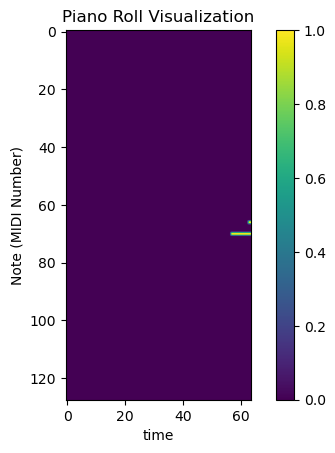

In [59]:
print_piano_roll(train_iter[1001][0].numpy().squeeze().transpose())

In [60]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

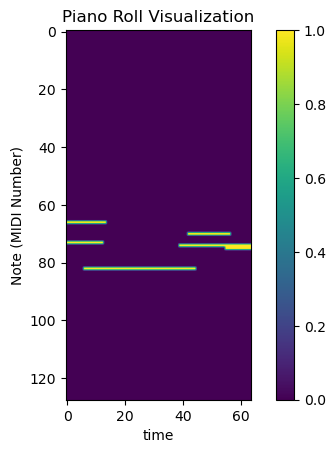

[0/30][0/990]	Loss_D: 1.4058	Loss_G: 11.2791	D(x): 0.5113	D(G(z)): 0.5143 / 0.4705
[0/30][15/990]	Loss_D: 1.2749	Loss_G: 8.7172	D(x): 0.4914	D(G(z)): 0.4215 / 0.4058
[0/30][30/990]	Loss_D: 1.1691	Loss_G: 6.6114	D(x): 0.5109	D(G(z)): 0.3702 / 0.3778
[0/30][45/990]	Loss_D: 1.1281	Loss_G: 5.1783	D(x): 0.5425	D(G(z)): 0.3729 / 0.3362
[0/30][60/990]	Loss_D: 1.0694	Loss_G: 4.2171	D(x): 0.5656	D(G(z)): 0.3505 / 0.3248
[0/30][75/990]	Loss_D: 1.0463	Loss_G: 3.5771	D(x): 0.6075	D(G(z)): 0.3547 / 0.3481
[0/30][90/990]	Loss_D: 0.8844	Loss_G: 3.2119	D(x): 0.6447	D(G(z)): 0.2782 / 0.3234
[0/30][105/990]	Loss_D: 0.8145	Loss_G: 3.0681	D(x): 0.6483	D(G(z)): 0.2216 / 0.3224
[0/30][120/990]	Loss_D: 0.9238	Loss_G: 3.0104	D(x): 0.6246	D(G(z)): 0.2868 / 0.2886
[0/30][135/990]	Loss_D: 0.7779	Loss_G: 2.9321	D(x): 0.6680	D(G(z)): 0.2158 / 0.2549
[0/30][150/990]	Loss_D: 0.8141	Loss_G: 3.0636	D(x): 0.6930	D(G(z)): 0.2452 / 0.2217
[0/30][165/990]	Loss_D: 0.8621	Loss_G: 3.8115	D(x): 0.7270	D(G(z)): 0.3189 / 0.1299

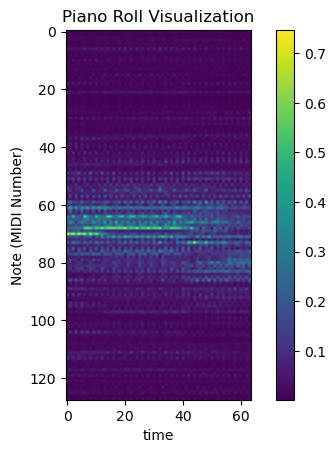

[1/30][0/990]	Loss_D: 0.7929	Loss_G: 2.4368	D(x): 0.7521	D(G(z)): 0.2132 / 0.1804
[1/30][15/990]	Loss_D: 0.8154	Loss_G: 2.3141	D(x): 0.7198	D(G(z)): 0.2453 / 0.1939
[1/30][30/990]	Loss_D: 1.0219	Loss_G: 2.2350	D(x): 0.7239	D(G(z)): 0.3333 / 0.2252
[1/30][45/990]	Loss_D: 0.8166	Loss_G: 2.2465	D(x): 0.6391	D(G(z)): 0.1817 / 0.2409
[1/30][60/990]	Loss_D: 1.0827	Loss_G: 2.2646	D(x): 0.5254	D(G(z)): 0.1250 / 0.2202
[1/30][75/990]	Loss_D: 0.7368	Loss_G: 2.9672	D(x): 0.7201	D(G(z)): 0.1873 / 0.1341
[1/30][90/990]	Loss_D: 0.9768	Loss_G: 2.7686	D(x): 0.6137	D(G(z)): 0.2510 / 0.1826
[1/30][105/990]	Loss_D: 0.9223	Loss_G: 2.5461	D(x): 0.6642	D(G(z)): 0.2490 / 0.1708
[1/30][120/990]	Loss_D: 0.8356	Loss_G: 2.2456	D(x): 0.7386	D(G(z)): 0.2693 / 0.2024
[1/30][135/990]	Loss_D: 0.8791	Loss_G: 2.4387	D(x): 0.7895	D(G(z)): 0.3294 / 0.1925
[1/30][150/990]	Loss_D: 0.7461	Loss_G: 2.9168	D(x): 0.6639	D(G(z)): 0.1285 / 0.1487
[1/30][165/990]	Loss_D: 0.9434	Loss_G: 2.6098	D(x): 0.6778	D(G(z)): 0.2663 / 0.1758


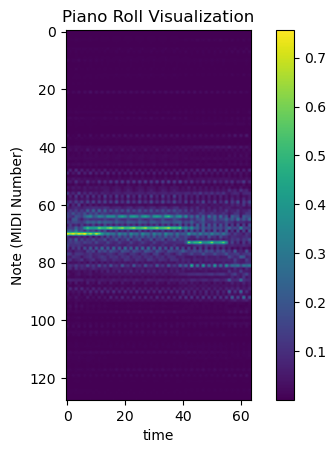

[2/30][0/990]	Loss_D: 0.8488	Loss_G: 2.3648	D(x): 0.7155	D(G(z)): 0.2205 / 0.1927
[2/30][15/990]	Loss_D: 0.8050	Loss_G: 2.3893	D(x): 0.7081	D(G(z)): 0.1598 / 0.1787
[2/30][30/990]	Loss_D: 1.0341	Loss_G: 2.2504	D(x): 0.6643	D(G(z)): 0.2981 / 0.2371
[2/30][45/990]	Loss_D: 0.7725	Loss_G: 2.6257	D(x): 0.7162	D(G(z)): 0.1797 / 0.1557
[2/30][60/990]	Loss_D: 0.8487	Loss_G: 2.6022	D(x): 0.8055	D(G(z)): 0.3109 / 0.1521
[2/30][75/990]	Loss_D: 0.6860	Loss_G: 2.6285	D(x): 0.7807	D(G(z)): 0.1950 / 0.1579
[2/30][90/990]	Loss_D: 0.8533	Loss_G: 2.4276	D(x): 0.5790	D(G(z)): 0.1242 / 0.1967
[2/30][105/990]	Loss_D: 0.8060	Loss_G: 2.4297	D(x): 0.7272	D(G(z)): 0.2230 / 0.1903
[2/30][120/990]	Loss_D: 0.8769	Loss_G: 2.0906	D(x): 0.6798	D(G(z)): 0.2422 / 0.2217
[2/30][135/990]	Loss_D: 0.8770	Loss_G: 2.2409	D(x): 0.6437	D(G(z)): 0.1703 / 0.1957
[2/30][150/990]	Loss_D: 0.8722	Loss_G: 2.4452	D(x): 0.7174	D(G(z)): 0.2453 / 0.1702
[2/30][165/990]	Loss_D: 0.8244	Loss_G: 2.4434	D(x): 0.6751	D(G(z)): 0.1656 / 0.1733


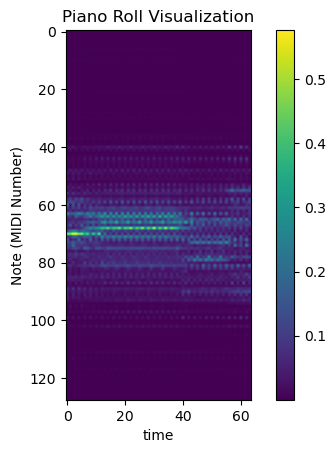

[3/30][0/990]	Loss_D: 0.9453	Loss_G: 2.3085	D(x): 0.5341	D(G(z)): 0.1489 / 0.1943
[3/30][15/990]	Loss_D: 0.8515	Loss_G: 2.1521	D(x): 0.7020	D(G(z)): 0.2342 / 0.2064
[3/30][30/990]	Loss_D: 0.8448	Loss_G: 2.4758	D(x): 0.7182	D(G(z)): 0.2527 / 0.1672
[3/30][45/990]	Loss_D: 0.7185	Loss_G: 2.3503	D(x): 0.7631	D(G(z)): 0.2119 / 0.1890
[3/30][60/990]	Loss_D: 0.8126	Loss_G: 2.3233	D(x): 0.7699	D(G(z)): 0.2610 / 0.1836
[3/30][75/990]	Loss_D: 1.0055	Loss_G: 1.8937	D(x): 0.7112	D(G(z)): 0.3151 / 0.2609
[3/30][90/990]	Loss_D: 1.3530	Loss_G: 1.8061	D(x): 0.4823	D(G(z)): 0.2325 / 0.3135
[3/30][105/990]	Loss_D: 0.8427	Loss_G: 2.1241	D(x): 0.7202	D(G(z)): 0.2367 / 0.2265
[3/30][120/990]	Loss_D: 0.7535	Loss_G: 2.5583	D(x): 0.7388	D(G(z)): 0.2156 / 0.1593
[3/30][135/990]	Loss_D: 0.8282	Loss_G: 2.1776	D(x): 0.6809	D(G(z)): 0.2047 / 0.2057
[3/30][150/990]	Loss_D: 0.7360	Loss_G: 2.3474	D(x): 0.7285	D(G(z)): 0.1822 / 0.1904
[3/30][165/990]	Loss_D: 0.7953	Loss_G: 2.3052	D(x): 0.7006	D(G(z)): 0.1816 / 0.1860


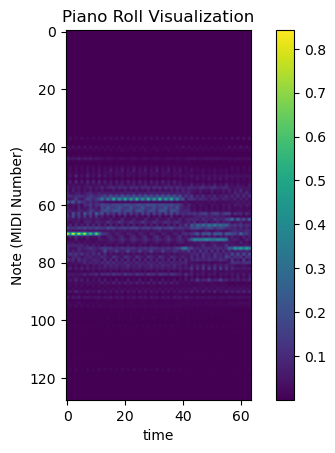

[4/30][0/990]	Loss_D: 0.7901	Loss_G: 2.4428	D(x): 0.7555	D(G(z)): 0.2285 / 0.1607
[4/30][15/990]	Loss_D: 0.7214	Loss_G: 2.6251	D(x): 0.7461	D(G(z)): 0.1732 / 0.1599
[4/30][30/990]	Loss_D: 0.7966	Loss_G: 2.6671	D(x): 0.7027	D(G(z)): 0.1614 / 0.1461
[4/30][45/990]	Loss_D: 0.9124	Loss_G: 2.3910	D(x): 0.7460	D(G(z)): 0.2700 / 0.1676
[4/30][60/990]	Loss_D: 0.9760	Loss_G: 2.4745	D(x): 0.6791	D(G(z)): 0.1940 / 0.1756
[4/30][75/990]	Loss_D: 0.8079	Loss_G: 2.6501	D(x): 0.6803	D(G(z)): 0.1287 / 0.1515
[4/30][90/990]	Loss_D: 0.9425	Loss_G: 2.2571	D(x): 0.6205	D(G(z)): 0.1837 / 0.2291
[4/30][105/990]	Loss_D: 0.9110	Loss_G: 2.4501	D(x): 0.7513	D(G(z)): 0.2547 / 0.1896
[4/30][120/990]	Loss_D: 0.7175	Loss_G: 2.7570	D(x): 0.7032	D(G(z)): 0.1338 / 0.1547
[4/30][135/990]	Loss_D: 0.9103	Loss_G: 2.2835	D(x): 0.6095	D(G(z)): 0.1772 / 0.2004
[4/30][150/990]	Loss_D: 0.7359	Loss_G: 2.6810	D(x): 0.7051	D(G(z)): 0.1277 / 0.1563
[4/30][165/990]	Loss_D: 0.7979	Loss_G: 2.3701	D(x): 0.7016	D(G(z)): 0.1901 / 0.1904


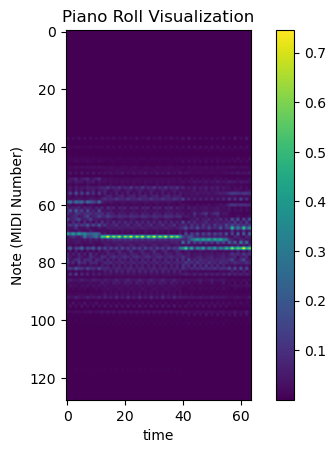

[5/30][0/990]	Loss_D: 0.7246	Loss_G: 2.4343	D(x): 0.7950	D(G(z)): 0.2228 / 0.2040
[5/30][15/990]	Loss_D: 0.9505	Loss_G: 2.7180	D(x): 0.5942	D(G(z)): 0.1309 / 0.1271
[5/30][30/990]	Loss_D: 0.7836	Loss_G: 2.6087	D(x): 0.6974	D(G(z)): 0.1837 / 0.1656
[5/30][45/990]	Loss_D: 0.9649	Loss_G: 2.0656	D(x): 0.6328	D(G(z)): 0.2292 / 0.2638
[5/30][60/990]	Loss_D: 0.8889	Loss_G: 2.5935	D(x): 0.6676	D(G(z)): 0.1957 / 0.1608
[5/30][75/990]	Loss_D: 0.8412	Loss_G: 2.1064	D(x): 0.6624	D(G(z)): 0.2057 / 0.2319
[5/30][90/990]	Loss_D: 0.7373	Loss_G: 2.7836	D(x): 0.6922	D(G(z)): 0.1071 / 0.1323
[5/30][105/990]	Loss_D: 1.0963	Loss_G: 1.7556	D(x): 0.5696	D(G(z)): 0.2369 / 0.3030
[5/30][120/990]	Loss_D: 0.7087	Loss_G: 2.1717	D(x): 0.7042	D(G(z)): 0.1586 / 0.1932
[5/30][135/990]	Loss_D: 0.9149	Loss_G: 2.1008	D(x): 0.6131	D(G(z)): 0.1678 / 0.2433
[5/30][150/990]	Loss_D: 0.9086	Loss_G: 2.1156	D(x): 0.6573	D(G(z)): 0.2259 / 0.2262
[5/30][165/990]	Loss_D: 0.8757	Loss_G: 2.1085	D(x): 0.6420	D(G(z)): 0.2039 / 0.2395


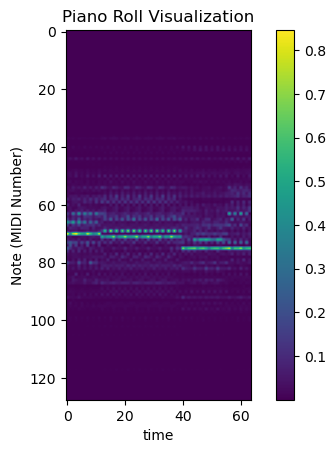

[6/30][0/990]	Loss_D: 0.7504	Loss_G: 2.4495	D(x): 0.7277	D(G(z)): 0.1822 / 0.1715
[6/30][15/990]	Loss_D: 0.8891	Loss_G: 2.4614	D(x): 0.6821	D(G(z)): 0.1850 / 0.1754
[6/30][30/990]	Loss_D: 0.6885	Loss_G: 2.6969	D(x): 0.7877	D(G(z)): 0.1790 / 0.1369
[6/30][45/990]	Loss_D: 0.7850	Loss_G: 2.2952	D(x): 0.7180	D(G(z)): 0.2022 / 0.1844
[6/30][60/990]	Loss_D: 0.8028	Loss_G: 2.3584	D(x): 0.6599	D(G(z)): 0.1452 / 0.1669
[6/30][75/990]	Loss_D: 0.8895	Loss_G: 2.5362	D(x): 0.7559	D(G(z)): 0.2697 / 0.1832
[6/30][90/990]	Loss_D: 0.7232	Loss_G: 2.3376	D(x): 0.7641	D(G(z)): 0.2059 / 0.1933
[6/30][105/990]	Loss_D: 0.8555	Loss_G: 2.2160	D(x): 0.6459	D(G(z)): 0.1640 / 0.2106
[6/30][120/990]	Loss_D: 0.7944	Loss_G: 2.1789	D(x): 0.7456	D(G(z)): 0.2251 / 0.2004
[6/30][135/990]	Loss_D: 0.8150	Loss_G: 2.3000	D(x): 0.7373	D(G(z)): 0.2124 / 0.1845
[6/30][150/990]	Loss_D: 0.8243	Loss_G: 2.4496	D(x): 0.6926	D(G(z)): 0.1860 / 0.1609
[6/30][165/990]	Loss_D: 0.7721	Loss_G: 2.3988	D(x): 0.7112	D(G(z)): 0.1833 / 0.1778


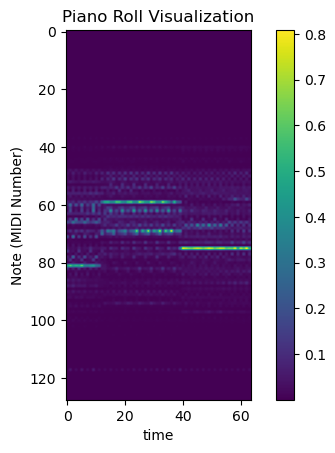

[7/30][0/990]	Loss_D: 0.7302	Loss_G: 2.4718	D(x): 0.7128	D(G(z)): 0.1477 / 0.1674
[7/30][15/990]	Loss_D: 0.9600	Loss_G: 2.4795	D(x): 0.5644	D(G(z)): 0.1453 / 0.1980
[7/30][30/990]	Loss_D: 0.8035	Loss_G: 2.1378	D(x): 0.8334	D(G(z)): 0.2553 / 0.2361
[7/30][45/990]	Loss_D: 0.8609	Loss_G: 2.5206	D(x): 0.7078	D(G(z)): 0.2228 / 0.1686
[7/30][60/990]	Loss_D: 0.8155	Loss_G: 2.2395	D(x): 0.7411	D(G(z)): 0.2401 / 0.2218
[7/30][75/990]	Loss_D: 0.8384	Loss_G: 2.2841	D(x): 0.6989	D(G(z)): 0.2200 / 0.2031
[7/30][90/990]	Loss_D: 0.9109	Loss_G: 2.5776	D(x): 0.6266	D(G(z)): 0.1615 / 0.1602
[7/30][105/990]	Loss_D: 0.7468	Loss_G: 2.3535	D(x): 0.7195	D(G(z)): 0.1646 / 0.1882
[7/30][120/990]	Loss_D: 0.6494	Loss_G: 2.7294	D(x): 0.7246	D(G(z)): 0.1117 / 0.1433
[7/30][135/990]	Loss_D: 0.8162	Loss_G: 2.2603	D(x): 0.7569	D(G(z)): 0.2572 / 0.2121
[7/30][150/990]	Loss_D: 0.8613	Loss_G: 2.1961	D(x): 0.6841	D(G(z)): 0.2136 / 0.2153
[7/30][165/990]	Loss_D: 0.7456	Loss_G: 2.4715	D(x): 0.7275	D(G(z)): 0.1728 / 0.1747


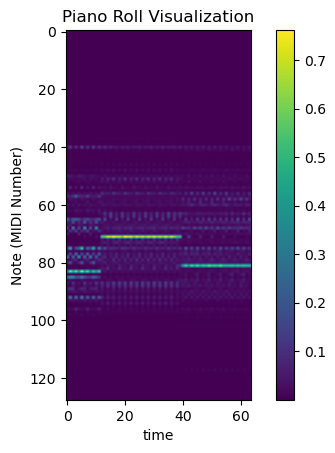

[8/30][0/990]	Loss_D: 0.7213	Loss_G: 2.5291	D(x): 0.7992	D(G(z)): 0.2077 / 0.1604
[8/30][15/990]	Loss_D: 0.7083	Loss_G: 2.4378	D(x): 0.7640	D(G(z)): 0.1641 / 0.1594
[8/30][30/990]	Loss_D: 0.7522	Loss_G: 2.9033	D(x): 0.7411	D(G(z)): 0.1620 / 0.1111
[8/30][45/990]	Loss_D: 0.8197	Loss_G: 2.7585	D(x): 0.6578	D(G(z)): 0.1043 / 0.1400
[8/30][60/990]	Loss_D: 0.6236	Loss_G: 2.7489	D(x): 0.7328	D(G(z)): 0.0808 / 0.1266
[8/30][75/990]	Loss_D: 0.9643	Loss_G: 2.2849	D(x): 0.6614	D(G(z)): 0.2337 / 0.2051
[8/30][90/990]	Loss_D: 0.7464	Loss_G: 2.2288	D(x): 0.7402	D(G(z)): 0.1938 / 0.2155
[8/30][105/990]	Loss_D: 0.9161	Loss_G: 2.3649	D(x): 0.6102	D(G(z)): 0.1595 / 0.1883
[8/30][120/990]	Loss_D: 0.8423	Loss_G: 2.3498	D(x): 0.7401	D(G(z)): 0.1953 / 0.1828
[8/30][135/990]	Loss_D: 0.8083	Loss_G: 2.2510	D(x): 0.7069	D(G(z)): 0.1667 / 0.1986
[8/30][150/990]	Loss_D: 0.7500	Loss_G: 2.3125	D(x): 0.6742	D(G(z)): 0.1381 / 0.1866
[8/30][165/990]	Loss_D: 0.7041	Loss_G: 2.7010	D(x): 0.7146	D(G(z)): 0.1122 / 0.1320


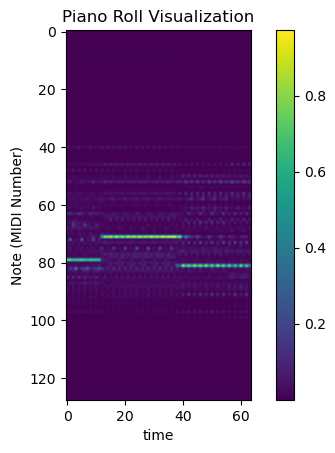

[9/30][0/990]	Loss_D: 0.9015	Loss_G: 2.5806	D(x): 0.7253	D(G(z)): 0.2560 / 0.1839
[9/30][15/990]	Loss_D: 0.7351	Loss_G: 2.7285	D(x): 0.7044	D(G(z)): 0.1435 / 0.1540
[9/30][30/990]	Loss_D: 0.6634	Loss_G: 3.1351	D(x): 0.7917	D(G(z)): 0.1597 / 0.0998
[9/30][45/990]	Loss_D: 0.9925	Loss_G: 2.4036	D(x): 0.6416	D(G(z)): 0.2432 / 0.1799
[9/30][60/990]	Loss_D: 0.7019	Loss_G: 3.0306	D(x): 0.8371	D(G(z)): 0.2023 / 0.1282
[9/30][75/990]	Loss_D: 0.7453	Loss_G: 2.7169	D(x): 0.8050	D(G(z)): 0.1958 / 0.1584
[9/30][90/990]	Loss_D: 0.9615	Loss_G: 2.3241	D(x): 0.5992	D(G(z)): 0.1887 / 0.2121
[9/30][105/990]	Loss_D: 0.8369	Loss_G: 2.4887	D(x): 0.6635	D(G(z)): 0.1477 / 0.1677
[9/30][120/990]	Loss_D: 0.9087	Loss_G: 2.2645	D(x): 0.7702	D(G(z)): 0.2937 / 0.2187
[9/30][135/990]	Loss_D: 0.6961	Loss_G: 2.4498	D(x): 0.7302	D(G(z)): 0.1402 / 0.1775
[9/30][150/990]	Loss_D: 0.7206	Loss_G: 2.8226	D(x): 0.7871	D(G(z)): 0.1907 / 0.1343
[9/30][165/990]	Loss_D: 0.6360	Loss_G: 2.4098	D(x): 0.8067	D(G(z)): 0.1739 / 0.1860


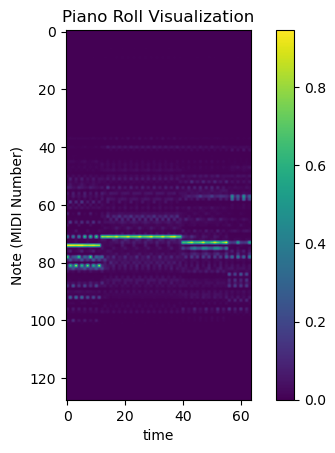

[10/30][0/990]	Loss_D: 0.8862	Loss_G: 2.4849	D(x): 0.7788	D(G(z)): 0.2490 / 0.1553
[10/30][15/990]	Loss_D: 0.7972	Loss_G: 2.8754	D(x): 0.6961	D(G(z)): 0.1250 / 0.1536
[10/30][30/990]	Loss_D: 0.8020	Loss_G: 2.6110	D(x): 0.7635	D(G(z)): 0.1977 / 0.1398
[10/30][45/990]	Loss_D: 0.7900	Loss_G: 2.2677	D(x): 0.7637	D(G(z)): 0.1949 / 0.1932
[10/30][60/990]	Loss_D: 0.8932	Loss_G: 2.8373	D(x): 0.6328	D(G(z)): 0.1533 / 0.1421
[10/30][75/990]	Loss_D: 0.8233	Loss_G: 2.4272	D(x): 0.6678	D(G(z)): 0.1521 / 0.1910
[10/30][90/990]	Loss_D: 0.9052	Loss_G: 2.1624	D(x): 0.7066	D(G(z)): 0.2159 / 0.2298
[10/30][105/990]	Loss_D: 0.8557	Loss_G: 2.2739	D(x): 0.7027	D(G(z)): 0.2240 / 0.1976
[10/30][120/990]	Loss_D: 0.7557	Loss_G: 2.6228	D(x): 0.7770	D(G(z)): 0.1898 / 0.1580
[10/30][135/990]	Loss_D: 0.8060	Loss_G: 2.4410	D(x): 0.7218	D(G(z)): 0.1611 / 0.1693
[10/30][150/990]	Loss_D: 1.0281	Loss_G: 2.0347	D(x): 0.6051	D(G(z)): 0.2286 / 0.2490
[10/30][165/990]	Loss_D: 0.6317	Loss_G: 2.6822	D(x): 0.8273	D(G(z)): 0.16

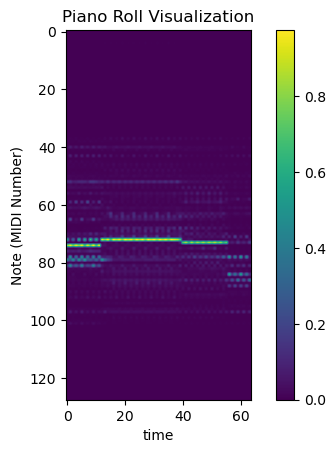

[11/30][0/990]	Loss_D: 0.6763	Loss_G: 2.7862	D(x): 0.7875	D(G(z)): 0.1731 / 0.1205
[11/30][15/990]	Loss_D: 0.7361	Loss_G: 2.2185	D(x): 0.7776	D(G(z)): 0.1992 / 0.1921
[11/30][30/990]	Loss_D: 0.7360	Loss_G: 2.2830	D(x): 0.8256	D(G(z)): 0.1848 / 0.1920
[11/30][45/990]	Loss_D: 0.8176	Loss_G: 2.6083	D(x): 0.7330	D(G(z)): 0.2246 / 0.1530
[11/30][60/990]	Loss_D: 0.6567	Loss_G: 2.7833	D(x): 0.7920	D(G(z)): 0.1571 / 0.1435
[11/30][75/990]	Loss_D: 0.8057	Loss_G: 2.3640	D(x): 0.7724	D(G(z)): 0.2382 / 0.2043
[11/30][90/990]	Loss_D: 0.8084	Loss_G: 2.4760	D(x): 0.7104	D(G(z)): 0.1797 / 0.1988
[11/30][105/990]	Loss_D: 0.7685	Loss_G: 3.0373	D(x): 0.7630	D(G(z)): 0.1670 / 0.1138
[11/30][120/990]	Loss_D: 0.9103	Loss_G: 2.4713	D(x): 0.6267	D(G(z)): 0.1655 / 0.1697
[11/30][135/990]	Loss_D: 0.8564	Loss_G: 2.5628	D(x): 0.6492	D(G(z)): 0.1481 / 0.1728
[11/30][150/990]	Loss_D: 0.8667	Loss_G: 2.3972	D(x): 0.6611	D(G(z)): 0.1597 / 0.1893
[11/30][165/990]	Loss_D: 0.8611	Loss_G: 2.7902	D(x): 0.6171	D(G(z)): 0.14

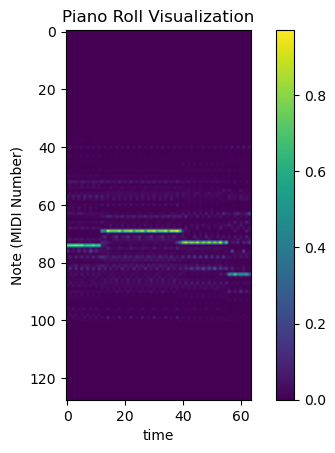

[12/30][0/990]	Loss_D: 0.7932	Loss_G: 2.5446	D(x): 0.7942	D(G(z)): 0.2453 / 0.1619
[12/30][15/990]	Loss_D: 0.8408	Loss_G: 2.5937	D(x): 0.6859	D(G(z)): 0.1628 / 0.1549
[12/30][30/990]	Loss_D: 0.6691	Loss_G: 2.6660	D(x): 0.7162	D(G(z)): 0.1251 / 0.1443
[12/30][45/990]	Loss_D: 0.8702	Loss_G: 2.7186	D(x): 0.7778	D(G(z)): 0.2535 / 0.1522
[12/30][60/990]	Loss_D: 0.8319	Loss_G: 2.3248	D(x): 0.6951	D(G(z)): 0.2142 / 0.2188
[12/30][75/990]	Loss_D: 0.6695	Loss_G: 2.7662	D(x): 0.7638	D(G(z)): 0.1059 / 0.1323
[12/30][90/990]	Loss_D: 0.7742	Loss_G: 2.6470	D(x): 0.6584	D(G(z)): 0.1321 / 0.1549
[12/30][105/990]	Loss_D: 0.7169	Loss_G: 2.7996	D(x): 0.7953	D(G(z)): 0.1949 / 0.1377
[12/30][120/990]	Loss_D: 0.8535	Loss_G: 2.9169	D(x): 0.6132	D(G(z)): 0.1083 / 0.1316
[12/30][135/990]	Loss_D: 0.9132	Loss_G: 2.3350	D(x): 0.6938	D(G(z)): 0.2070 / 0.1961
[12/30][150/990]	Loss_D: 0.7960	Loss_G: 2.3491	D(x): 0.7866	D(G(z)): 0.2247 / 0.1946
[12/30][165/990]	Loss_D: 0.8417	Loss_G: 2.4325	D(x): 0.8244	D(G(z)): 0.27

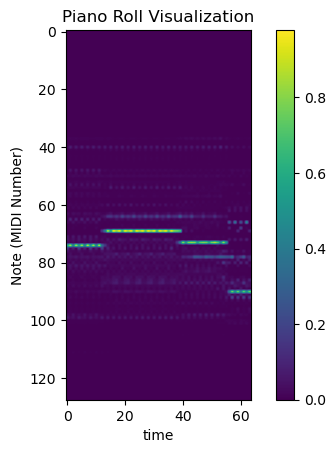

[13/30][0/990]	Loss_D: 0.8425	Loss_G: 2.5942	D(x): 0.6902	D(G(z)): 0.1751 / 0.1648
[13/30][15/990]	Loss_D: 0.7835	Loss_G: 2.2151	D(x): 0.6633	D(G(z)): 0.1444 / 0.2166
[13/30][30/990]	Loss_D: 0.7368	Loss_G: 2.3586	D(x): 0.7491	D(G(z)): 0.1881 / 0.1944
[13/30][45/990]	Loss_D: 0.8514	Loss_G: 2.0396	D(x): 0.6812	D(G(z)): 0.1547 / 0.2269
[13/30][60/990]	Loss_D: 0.7231	Loss_G: 2.6867	D(x): 0.8566	D(G(z)): 0.2095 / 0.1243
[13/30][75/990]	Loss_D: 0.7424	Loss_G: 2.5238	D(x): 0.6890	D(G(z)): 0.1627 / 0.1693
[13/30][90/990]	Loss_D: 0.8370	Loss_G: 2.4110	D(x): 0.6648	D(G(z)): 0.1666 / 0.1674
[13/30][105/990]	Loss_D: 0.8571	Loss_G: 2.1503	D(x): 0.6397	D(G(z)): 0.1708 / 0.2070
[13/30][120/990]	Loss_D: 0.8523	Loss_G: 2.4131	D(x): 0.6887	D(G(z)): 0.2156 / 0.1557
[13/30][135/990]	Loss_D: 0.8587	Loss_G: 2.4080	D(x): 0.6712	D(G(z)): 0.1726 / 0.1833
[13/30][150/990]	Loss_D: 0.6224	Loss_G: 3.0959	D(x): 0.8384	D(G(z)): 0.1635 / 0.0985
[13/30][165/990]	Loss_D: 0.9177	Loss_G: 2.5733	D(x): 0.7360	D(G(z)): 0.24

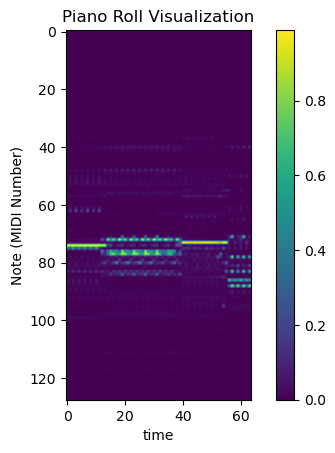

[14/30][0/990]	Loss_D: 0.6641	Loss_G: 2.8198	D(x): 0.7332	D(G(z)): 0.1300 / 0.1214
[14/30][15/990]	Loss_D: 0.8740	Loss_G: 2.2708	D(x): 0.6678	D(G(z)): 0.1967 / 0.2145
[14/30][30/990]	Loss_D: 0.6776	Loss_G: 3.0046	D(x): 0.7243	D(G(z)): 0.0938 / 0.1044
[14/30][45/990]	Loss_D: 0.8999	Loss_G: 2.6674	D(x): 0.6537	D(G(z)): 0.1454 / 0.1444
[14/30][60/990]	Loss_D: 0.7028	Loss_G: 2.8562	D(x): 0.7699	D(G(z)): 0.1319 / 0.1268
[14/30][75/990]	Loss_D: 0.7788	Loss_G: 2.6634	D(x): 0.6911	D(G(z)): 0.1494 / 0.1711
[14/30][90/990]	Loss_D: 0.8551	Loss_G: 2.8845	D(x): 0.6351	D(G(z)): 0.1320 / 0.1294
[14/30][105/990]	Loss_D: 0.7679	Loss_G: 2.5369	D(x): 0.7081	D(G(z)): 0.1809 / 0.1681
[14/30][120/990]	Loss_D: 0.8005	Loss_G: 2.4626	D(x): 0.6779	D(G(z)): 0.1777 / 0.1608
[14/30][135/990]	Loss_D: 0.8130	Loss_G: 2.3667	D(x): 0.6470	D(G(z)): 0.1553 / 0.2118
[14/30][150/990]	Loss_D: 0.8704	Loss_G: 2.5816	D(x): 0.6783	D(G(z)): 0.1715 / 0.1905
[14/30][165/990]	Loss_D: 0.6828	Loss_G: 2.8617	D(x): 0.7132	D(G(z)): 0.13

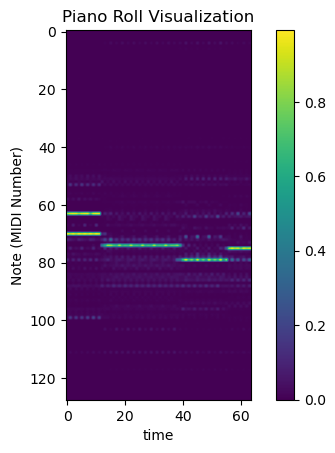

[15/30][0/990]	Loss_D: 0.6988	Loss_G: 2.8527	D(x): 0.7368	D(G(z)): 0.1270 / 0.1336
[15/30][15/990]	Loss_D: 0.7538	Loss_G: 2.6177	D(x): 0.8126	D(G(z)): 0.2324 / 0.1533
[15/30][30/990]	Loss_D: 0.6908	Loss_G: 2.9766	D(x): 0.7651	D(G(z)): 0.1459 / 0.1005
[15/30][45/990]	Loss_D: 0.7145	Loss_G: 2.9292	D(x): 0.7617	D(G(z)): 0.1328 / 0.1124
[15/30][60/990]	Loss_D: 0.8810	Loss_G: 2.6241	D(x): 0.6783	D(G(z)): 0.1940 / 0.1527
[15/30][75/990]	Loss_D: 0.7399	Loss_G: 2.5803	D(x): 0.7755	D(G(z)): 0.1807 / 0.1522
[15/30][90/990]	Loss_D: 0.6734	Loss_G: 2.5473	D(x): 0.6763	D(G(z)): 0.0855 / 0.1774
[15/30][105/990]	Loss_D: 0.7697	Loss_G: 2.4939	D(x): 0.6971	D(G(z)): 0.1390 / 0.1551
[15/30][120/990]	Loss_D: 0.7480	Loss_G: 3.0065	D(x): 0.7073	D(G(z)): 0.1586 / 0.1166
[15/30][135/990]	Loss_D: 0.6632	Loss_G: 3.0774	D(x): 0.7624	D(G(z)): 0.1117 / 0.1043
[15/30][150/990]	Loss_D: 0.6577	Loss_G: 2.8533	D(x): 0.7222	D(G(z)): 0.0910 / 0.1100
[15/30][165/990]	Loss_D: 0.6668	Loss_G: 2.7320	D(x): 0.7693	D(G(z)): 0.13

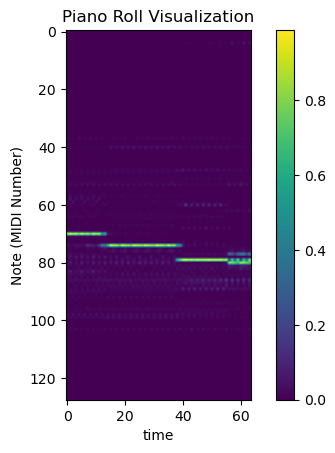

[16/30][0/990]	Loss_D: 0.6159	Loss_G: 2.9934	D(x): 0.7910	D(G(z)): 0.1244 / 0.1239
[16/30][15/990]	Loss_D: 0.6726	Loss_G: 2.7461	D(x): 0.7902	D(G(z)): 0.1492 / 0.1203
[16/30][30/990]	Loss_D: 0.8193	Loss_G: 2.6680	D(x): 0.6386	D(G(z)): 0.1264 / 0.1477
[16/30][45/990]	Loss_D: 0.7882	Loss_G: 2.5154	D(x): 0.7154	D(G(z)): 0.1524 / 0.1810
[16/30][60/990]	Loss_D: 0.7903	Loss_G: 2.9476	D(x): 0.7573	D(G(z)): 0.1928 / 0.1110
[16/30][75/990]	Loss_D: 0.6363	Loss_G: 2.7656	D(x): 0.7777	D(G(z)): 0.1308 / 0.1186
[16/30][90/990]	Loss_D: 0.8254	Loss_G: 2.3576	D(x): 0.7220	D(G(z)): 0.2170 / 0.1819
[16/30][105/990]	Loss_D: 0.6728	Loss_G: 2.7828	D(x): 0.7700	D(G(z)): 0.1271 / 0.1342
[16/30][120/990]	Loss_D: 0.5867	Loss_G: 2.6937	D(x): 0.8482	D(G(z)): 0.1423 / 0.1441
[16/30][135/990]	Loss_D: 0.5343	Loss_G: 3.0672	D(x): 0.8468	D(G(z)): 0.1076 / 0.1077
[16/30][150/990]	Loss_D: 0.6452	Loss_G: 2.9910	D(x): 0.7265	D(G(z)): 0.1120 / 0.1147
[16/30][165/990]	Loss_D: 0.6386	Loss_G: 3.1063	D(x): 0.8443	D(G(z)): 0.13

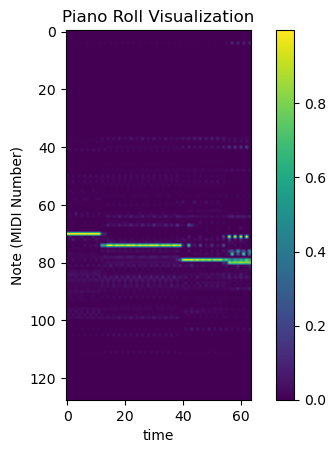

[17/30][0/990]	Loss_D: 0.7312	Loss_G: 2.5300	D(x): 0.7180	D(G(z)): 0.1173 / 0.1917
[17/30][15/990]	Loss_D: 0.7080	Loss_G: 2.8225	D(x): 0.7527	D(G(z)): 0.1456 / 0.1280
[17/30][30/990]	Loss_D: 0.8624	Loss_G: 2.5159	D(x): 0.7253	D(G(z)): 0.2196 / 0.1663
[17/30][45/990]	Loss_D: 0.6055	Loss_G: 3.3441	D(x): 0.7514	D(G(z)): 0.0839 / 0.0952
[17/30][60/990]	Loss_D: 0.7137	Loss_G: 2.8056	D(x): 0.7610	D(G(z)): 0.1526 / 0.1275
[17/30][75/990]	Loss_D: 0.6919	Loss_G: 3.3336	D(x): 0.7608	D(G(z)): 0.1117 / 0.0844
[17/30][90/990]	Loss_D: 0.6978	Loss_G: 2.6854	D(x): 0.7447	D(G(z)): 0.1628 / 0.1635
[17/30][105/990]	Loss_D: 0.9587	Loss_G: 2.6804	D(x): 0.5694	D(G(z)): 0.0673 / 0.1648
[17/30][120/990]	Loss_D: 0.7789	Loss_G: 2.1809	D(x): 0.8110	D(G(z)): 0.1917 / 0.2545
[17/30][135/990]	Loss_D: 0.7093	Loss_G: 2.9305	D(x): 0.8027	D(G(z)): 0.1593 / 0.1329
[17/30][150/990]	Loss_D: 0.6842	Loss_G: 2.8011	D(x): 0.7809	D(G(z)): 0.1407 / 0.1302
[17/30][165/990]	Loss_D: 0.6211	Loss_G: 3.0807	D(x): 0.7320	D(G(z)): 0.07

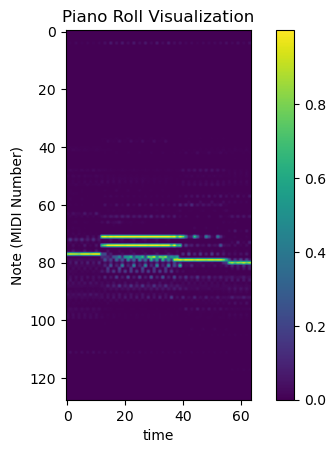

[18/30][0/990]	Loss_D: 0.7600	Loss_G: 3.0151	D(x): 0.7791	D(G(z)): 0.1325 / 0.1231
[18/30][15/990]	Loss_D: 0.7818	Loss_G: 2.7241	D(x): 0.7529	D(G(z)): 0.1449 / 0.1717
[18/30][30/990]	Loss_D: 0.7257	Loss_G: 2.4772	D(x): 0.7907	D(G(z)): 0.1956 / 0.1757
[18/30][45/990]	Loss_D: 0.8628	Loss_G: 2.4170	D(x): 0.7457	D(G(z)): 0.2170 / 0.1844
[18/30][60/990]	Loss_D: 0.7378	Loss_G: 2.7555	D(x): 0.6541	D(G(z)): 0.0838 / 0.1319
[18/30][75/990]	Loss_D: 0.6783	Loss_G: 3.2361	D(x): 0.7450	D(G(z)): 0.1413 / 0.1013
[18/30][90/990]	Loss_D: 0.6721	Loss_G: 2.7929	D(x): 0.8024	D(G(z)): 0.1632 / 0.1370
[18/30][105/990]	Loss_D: 0.6781	Loss_G: 3.3164	D(x): 0.7261	D(G(z)): 0.1162 / 0.0846
[18/30][120/990]	Loss_D: 0.6643	Loss_G: 2.5331	D(x): 0.8450	D(G(z)): 0.1927 / 0.1672
[18/30][135/990]	Loss_D: 0.7229	Loss_G: 3.1565	D(x): 0.6876	D(G(z)): 0.1209 / 0.1014
[18/30][150/990]	Loss_D: 0.6988	Loss_G: 2.7741	D(x): 0.7364	D(G(z)): 0.1290 / 0.1364
[18/30][165/990]	Loss_D: 0.7025	Loss_G: 2.8931	D(x): 0.7595	D(G(z)): 0.15

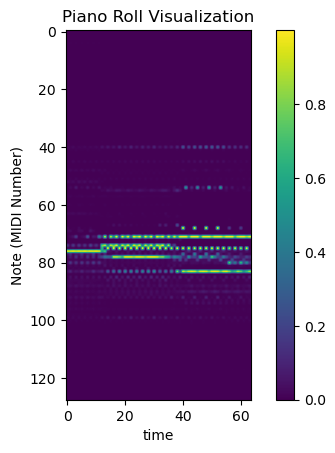

[19/30][0/990]	Loss_D: 0.6841	Loss_G: 2.7960	D(x): 0.7564	D(G(z)): 0.1460 / 0.1198
[19/30][15/990]	Loss_D: 0.6630	Loss_G: 2.9244	D(x): 0.8150	D(G(z)): 0.1650 / 0.1052
[19/30][30/990]	Loss_D: 0.6485	Loss_G: 3.0803	D(x): 0.7505	D(G(z)): 0.1156 / 0.0990
[19/30][45/990]	Loss_D: 0.6813	Loss_G: 3.1936	D(x): 0.7028	D(G(z)): 0.1003 / 0.1173
[19/30][60/990]	Loss_D: 0.6886	Loss_G: 3.3456	D(x): 0.8064	D(G(z)): 0.1531 / 0.0868
[19/30][75/990]	Loss_D: 0.6622	Loss_G: 2.8530	D(x): 0.7921	D(G(z)): 0.1328 / 0.1395
[19/30][90/990]	Loss_D: 0.6739	Loss_G: 3.2502	D(x): 0.7627	D(G(z)): 0.1240 / 0.0926
[19/30][105/990]	Loss_D: 0.6930	Loss_G: 2.8885	D(x): 0.6694	D(G(z)): 0.0890 / 0.1153
[19/30][120/990]	Loss_D: 0.6810	Loss_G: 2.7509	D(x): 0.7878	D(G(z)): 0.1774 / 0.1304
[19/30][135/990]	Loss_D: 0.6486	Loss_G: 3.1031	D(x): 0.7377	D(G(z)): 0.1008 / 0.1103
[19/30][150/990]	Loss_D: 0.6153	Loss_G: 3.1002	D(x): 0.8552	D(G(z)): 0.1261 / 0.1014
[19/30][165/990]	Loss_D: 0.7052	Loss_G: 3.1848	D(x): 0.7204	D(G(z)): 0.12

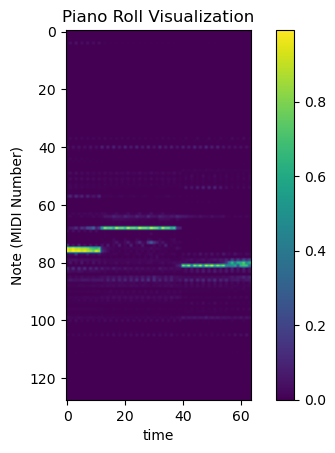

[20/30][0/990]	Loss_D: 0.7099	Loss_G: 2.7624	D(x): 0.8239	D(G(z)): 0.1673 / 0.1410
[20/30][15/990]	Loss_D: 0.6355	Loss_G: 2.9583	D(x): 0.7389	D(G(z)): 0.0976 / 0.1169
[20/30][30/990]	Loss_D: 0.7500	Loss_G: 2.6258	D(x): 0.6929	D(G(z)): 0.1433 / 0.1900
[20/30][45/990]	Loss_D: 0.7134	Loss_G: 3.1826	D(x): 0.7487	D(G(z)): 0.1187 / 0.0990
[20/30][60/990]	Loss_D: 0.6678	Loss_G: 3.2016	D(x): 0.7334	D(G(z)): 0.1169 / 0.1047
[20/30][75/990]	Loss_D: 0.6926	Loss_G: 2.7943	D(x): 0.7858	D(G(z)): 0.1618 / 0.1475
[20/30][90/990]	Loss_D: 0.6837	Loss_G: 2.7252	D(x): 0.7127	D(G(z)): 0.0836 / 0.1418
[20/30][105/990]	Loss_D: 0.8117	Loss_G: 2.9975	D(x): 0.6574	D(G(z)): 0.1193 / 0.1097
[20/30][120/990]	Loss_D: 0.6613	Loss_G: 3.1535	D(x): 0.7948	D(G(z)): 0.1503 / 0.1124
[20/30][135/990]	Loss_D: 0.5837	Loss_G: 3.0600	D(x): 0.7726	D(G(z)): 0.1028 / 0.1047
[20/30][150/990]	Loss_D: 0.7195	Loss_G: 2.9626	D(x): 0.7471	D(G(z)): 0.0953 / 0.1231
[20/30][165/990]	Loss_D: 0.7073	Loss_G: 3.4476	D(x): 0.7550	D(G(z)): 0.06

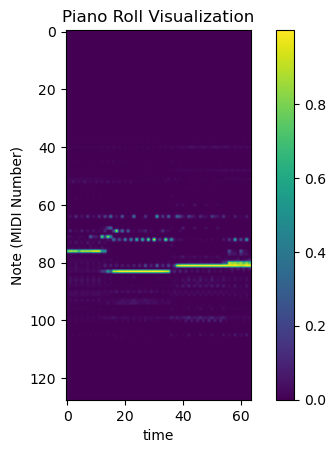

[21/30][0/990]	Loss_D: 0.8290	Loss_G: 2.6356	D(x): 0.7712	D(G(z)): 0.1951 / 0.1821
[21/30][15/990]	Loss_D: 0.5877	Loss_G: 3.0683	D(x): 0.8245	D(G(z)): 0.1444 / 0.1107
[21/30][30/990]	Loss_D: 0.6418	Loss_G: 3.1734	D(x): 0.7636	D(G(z)): 0.1208 / 0.0991
[21/30][45/990]	Loss_D: 0.7490	Loss_G: 2.8912	D(x): 0.7854	D(G(z)): 0.1830 / 0.1332
[21/30][60/990]	Loss_D: 0.6328	Loss_G: 3.0152	D(x): 0.8031	D(G(z)): 0.1243 / 0.1285
[21/30][75/990]	Loss_D: 0.6983	Loss_G: 3.0706	D(x): 0.7017	D(G(z)): 0.1166 / 0.1017
[21/30][90/990]	Loss_D: 0.5612	Loss_G: 3.2084	D(x): 0.8506	D(G(z)): 0.1464 / 0.1088
[21/30][105/990]	Loss_D: 0.7205	Loss_G: 3.3091	D(x): 0.7503	D(G(z)): 0.1623 / 0.1000
[21/30][120/990]	Loss_D: 0.6538	Loss_G: 3.0507	D(x): 0.7685	D(G(z)): 0.1336 / 0.1237
[21/30][135/990]	Loss_D: 0.6307	Loss_G: 3.4191	D(x): 0.7538	D(G(z)): 0.1044 / 0.1047
[21/30][150/990]	Loss_D: 0.7735	Loss_G: 2.8626	D(x): 0.6824	D(G(z)): 0.1236 / 0.1305
[21/30][165/990]	Loss_D: 0.6373	Loss_G: 2.6466	D(x): 0.7846	D(G(z)): 0.12

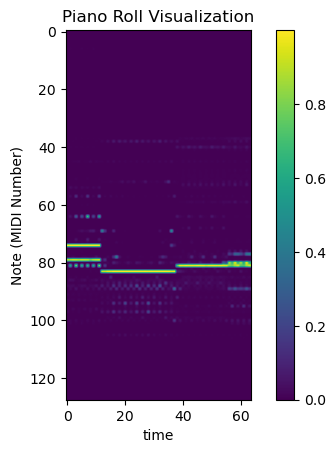

[22/30][0/990]	Loss_D: 0.7622	Loss_G: 2.7454	D(x): 0.7303	D(G(z)): 0.1476 / 0.1521
[22/30][15/990]	Loss_D: 0.5939	Loss_G: 2.8306	D(x): 0.7777	D(G(z)): 0.1108 / 0.1490
[22/30][30/990]	Loss_D: 0.6423	Loss_G: 3.2059	D(x): 0.8004	D(G(z)): 0.1350 / 0.1066
[22/30][45/990]	Loss_D: 0.8632	Loss_G: 2.8729	D(x): 0.6827	D(G(z)): 0.1511 / 0.1233
[22/30][60/990]	Loss_D: 0.6335	Loss_G: 3.1014	D(x): 0.7125	D(G(z)): 0.0954 / 0.1053
[22/30][75/990]	Loss_D: 0.6673	Loss_G: 2.6980	D(x): 0.7687	D(G(z)): 0.1329 / 0.1308
[22/30][90/990]	Loss_D: 0.6015	Loss_G: 2.9238	D(x): 0.7868	D(G(z)): 0.1164 / 0.1123
[22/30][105/990]	Loss_D: 0.9129	Loss_G: 2.4242	D(x): 0.6606	D(G(z)): 0.1780 / 0.1863
[22/30][120/990]	Loss_D: 0.6282	Loss_G: 3.5054	D(x): 0.7645	D(G(z)): 0.1114 / 0.0813
[22/30][135/990]	Loss_D: 0.5436	Loss_G: 3.6561	D(x): 0.8326	D(G(z)): 0.0541 / 0.0662
[22/30][150/990]	Loss_D: 0.6513	Loss_G: 2.9949	D(x): 0.8193	D(G(z)): 0.1539 / 0.1170
[22/30][165/990]	Loss_D: 0.7237	Loss_G: 2.9763	D(x): 0.7194	D(G(z)): 0.15

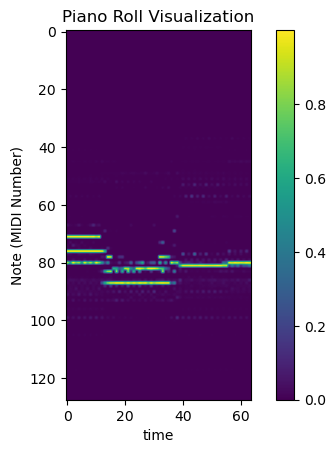

[23/30][0/990]	Loss_D: 0.7882	Loss_G: 2.6869	D(x): 0.6992	D(G(z)): 0.1568 / 0.1457
[23/30][15/990]	Loss_D: 0.6338	Loss_G: 2.8204	D(x): 0.7914	D(G(z)): 0.1512 / 0.1423
[23/30][30/990]	Loss_D: 0.6198	Loss_G: 2.9483	D(x): 0.7564	D(G(z)): 0.1095 / 0.1375
[23/30][45/990]	Loss_D: 0.7436	Loss_G: 2.4843	D(x): 0.8007	D(G(z)): 0.1947 / 0.2031
[23/30][60/990]	Loss_D: 0.6084	Loss_G: 2.8353	D(x): 0.7900	D(G(z)): 0.1247 / 0.1370
[23/30][75/990]	Loss_D: 0.7332	Loss_G: 2.6290	D(x): 0.7398	D(G(z)): 0.1652 / 0.1398
[23/30][90/990]	Loss_D: 0.7783	Loss_G: 2.4603	D(x): 0.6660	D(G(z)): 0.1286 / 0.1892
[23/30][105/990]	Loss_D: 0.6881	Loss_G: 2.8220	D(x): 0.7924	D(G(z)): 0.1872 / 0.1458
[23/30][120/990]	Loss_D: 0.6503	Loss_G: 2.9310	D(x): 0.8108	D(G(z)): 0.1605 / 0.1272
[23/30][135/990]	Loss_D: 0.6683	Loss_G: 2.6993	D(x): 0.7948	D(G(z)): 0.1624 / 0.1714
[23/30][150/990]	Loss_D: 0.6191	Loss_G: 2.9668	D(x): 0.8120	D(G(z)): 0.1477 / 0.1230
[23/30][165/990]	Loss_D: 0.7234	Loss_G: 2.6678	D(x): 0.7470	D(G(z)): 0.15

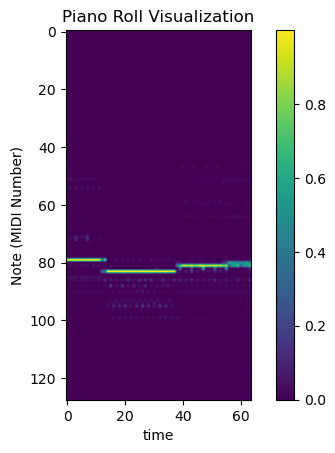

[24/30][0/990]	Loss_D: 0.7456	Loss_G: 3.0529	D(x): 0.7257	D(G(z)): 0.1490 / 0.1201
[24/30][15/990]	Loss_D: 0.6624	Loss_G: 3.5735	D(x): 0.7415	D(G(z)): 0.1207 / 0.0872
[24/30][30/990]	Loss_D: 0.6302	Loss_G: 3.3505	D(x): 0.8029	D(G(z)): 0.1221 / 0.0975
[24/30][45/990]	Loss_D: 0.6153	Loss_G: 3.0428	D(x): 0.7983	D(G(z)): 0.1177 / 0.1270
[24/30][60/990]	Loss_D: 0.6957	Loss_G: 3.2162	D(x): 0.7509	D(G(z)): 0.1353 / 0.1225
[24/30][75/990]	Loss_D: 0.6084	Loss_G: 3.3718	D(x): 0.7464	D(G(z)): 0.0997 / 0.0942
[24/30][90/990]	Loss_D: 0.7124	Loss_G: 2.9107	D(x): 0.7421	D(G(z)): 0.1481 / 0.1533
[24/30][105/990]	Loss_D: 0.7258	Loss_G: 3.0853	D(x): 0.7753	D(G(z)): 0.1924 / 0.1246
[24/30][120/990]	Loss_D: 0.5671	Loss_G: 3.0721	D(x): 0.8393	D(G(z)): 0.1331 / 0.1114
[24/30][135/990]	Loss_D: 0.5547	Loss_G: 3.2411	D(x): 0.7982	D(G(z)): 0.0967 / 0.0858
[24/30][150/990]	Loss_D: 0.6965	Loss_G: 2.9492	D(x): 0.7825	D(G(z)): 0.1444 / 0.1157
[24/30][165/990]	Loss_D: 0.6512	Loss_G: 2.7491	D(x): 0.8274	D(G(z)): 0.15

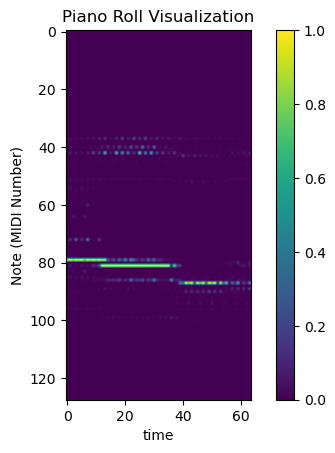

[25/30][0/990]	Loss_D: 0.6850	Loss_G: 2.9729	D(x): 0.7320	D(G(z)): 0.1155 / 0.1244
[25/30][15/990]	Loss_D: 0.5725	Loss_G: 3.3860	D(x): 0.8666	D(G(z)): 0.1259 / 0.1059
[25/30][30/990]	Loss_D: 0.8113	Loss_G: 2.9052	D(x): 0.7171	D(G(z)): 0.1654 / 0.1675
[25/30][45/990]	Loss_D: 0.6405	Loss_G: 2.8777	D(x): 0.8123	D(G(z)): 0.1434 / 0.1309
[25/30][60/990]	Loss_D: 0.5988	Loss_G: 3.1100	D(x): 0.7654	D(G(z)): 0.0906 / 0.1229
[25/30][75/990]	Loss_D: 0.6592	Loss_G: 3.0104	D(x): 0.7553	D(G(z)): 0.1277 / 0.1183
[25/30][90/990]	Loss_D: 0.6680	Loss_G: 3.0538	D(x): 0.7780	D(G(z)): 0.1310 / 0.1075
[25/30][105/990]	Loss_D: 0.6853	Loss_G: 2.7378	D(x): 0.7849	D(G(z)): 0.1321 / 0.1450
[25/30][120/990]	Loss_D: 0.7145	Loss_G: 2.9190	D(x): 0.7522	D(G(z)): 0.1260 / 0.1330
[25/30][135/990]	Loss_D: 0.6940	Loss_G: 3.3142	D(x): 0.7224	D(G(z)): 0.1074 / 0.0791
[25/30][150/990]	Loss_D: 0.6369	Loss_G: 3.1326	D(x): 0.8379	D(G(z)): 0.1490 / 0.1215
[25/30][165/990]	Loss_D: 0.6657	Loss_G: 3.3526	D(x): 0.8108	D(G(z)): 0.15

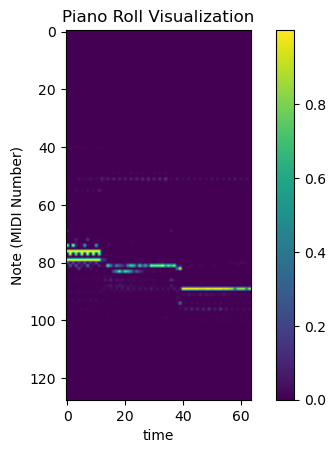

[26/30][0/990]	Loss_D: 0.7301	Loss_G: 2.7238	D(x): 0.8167	D(G(z)): 0.1772 / 0.1407
[26/30][15/990]	Loss_D: 0.6429	Loss_G: 3.4346	D(x): 0.7458	D(G(z)): 0.1065 / 0.0734
[26/30][30/990]	Loss_D: 0.6221	Loss_G: 2.9589	D(x): 0.7755	D(G(z)): 0.1100 / 0.1337
[26/30][45/990]	Loss_D: 0.6399	Loss_G: 2.9408	D(x): 0.8370	D(G(z)): 0.1701 / 0.1206
[26/30][60/990]	Loss_D: 0.7038	Loss_G: 2.7290	D(x): 0.7380	D(G(z)): 0.1335 / 0.1479
[26/30][75/990]	Loss_D: 0.7018	Loss_G: 2.9116	D(x): 0.6824	D(G(z)): 0.1123 / 0.1213
[26/30][90/990]	Loss_D: 0.7036	Loss_G: 2.9830	D(x): 0.8071	D(G(z)): 0.1658 / 0.1171
[26/30][105/990]	Loss_D: 0.6490	Loss_G: 3.1255	D(x): 0.8279	D(G(z)): 0.1619 / 0.1213
[26/30][120/990]	Loss_D: 0.6050	Loss_G: 3.3685	D(x): 0.7879	D(G(z)): 0.1033 / 0.0973
[26/30][135/990]	Loss_D: 0.7012	Loss_G: 3.0786	D(x): 0.7940	D(G(z)): 0.1620 / 0.1159
[26/30][150/990]	Loss_D: 0.5686	Loss_G: 3.7706	D(x): 0.8103	D(G(z)): 0.0830 / 0.0793
[26/30][165/990]	Loss_D: 0.5631	Loss_G: 3.4000	D(x): 0.7867	D(G(z)): 0.08

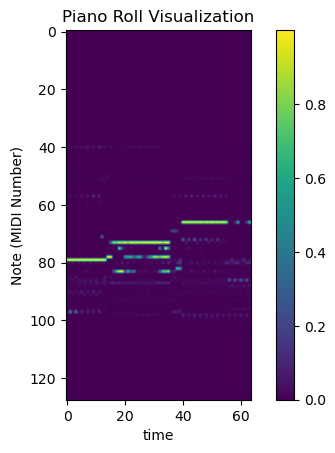

[27/30][0/990]	Loss_D: 0.6629	Loss_G: 3.1940	D(x): 0.8280	D(G(z)): 0.1719 / 0.1041
[27/30][15/990]	Loss_D: 0.6892	Loss_G: 3.4714	D(x): 0.7602	D(G(z)): 0.1426 / 0.0933
[27/30][30/990]	Loss_D: 0.6927	Loss_G: 3.4989	D(x): 0.7166	D(G(z)): 0.0946 / 0.0803
[27/30][45/990]	Loss_D: 0.6477	Loss_G: 3.0983	D(x): 0.8450	D(G(z)): 0.1554 / 0.1347
[27/30][60/990]	Loss_D: 0.6917	Loss_G: 3.0860	D(x): 0.7644	D(G(z)): 0.0966 / 0.1166
[27/30][75/990]	Loss_D: 0.6023	Loss_G: 3.2045	D(x): 0.7773	D(G(z)): 0.1034 / 0.1107
[27/30][90/990]	Loss_D: 0.5738	Loss_G: 3.4143	D(x): 0.8077	D(G(z)): 0.1066 / 0.1009
[27/30][105/990]	Loss_D: 0.6041	Loss_G: 2.9804	D(x): 0.7824	D(G(z)): 0.1277 / 0.1482
[27/30][120/990]	Loss_D: 0.6133	Loss_G: 3.7888	D(x): 0.8985	D(G(z)): 0.1569 / 0.0698
[27/30][135/990]	Loss_D: 0.7892	Loss_G: 3.3059	D(x): 0.7160	D(G(z)): 0.1392 / 0.1096
[27/30][150/990]	Loss_D: 0.7481	Loss_G: 2.5913	D(x): 0.7307	D(G(z)): 0.1492 / 0.1498
[27/30][165/990]	Loss_D: 0.6184	Loss_G: 2.7073	D(x): 0.7877	D(G(z)): 0.13

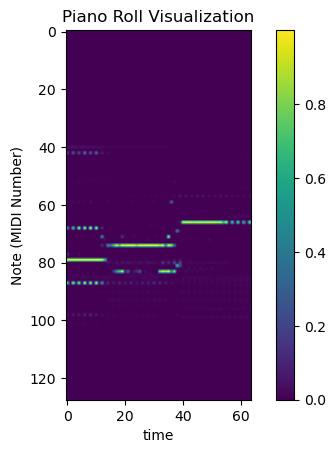

[28/30][0/990]	Loss_D: 1.0269	Loss_G: 3.1021	D(x): 0.6094	D(G(z)): 0.0996 / 0.1279
[28/30][15/990]	Loss_D: 0.6894	Loss_G: 3.1703	D(x): 0.6988	D(G(z)): 0.1018 / 0.1164
[28/30][30/990]	Loss_D: 0.6114	Loss_G: 3.5016	D(x): 0.7974	D(G(z)): 0.1061 / 0.0970
[28/30][45/990]	Loss_D: 0.6562	Loss_G: 3.5017	D(x): 0.7849	D(G(z)): 0.1510 / 0.0739
[28/30][60/990]	Loss_D: 0.5367	Loss_G: 3.4451	D(x): 0.8019	D(G(z)): 0.0842 / 0.0927
[28/30][75/990]	Loss_D: 0.6503	Loss_G: 3.0589	D(x): 0.7091	D(G(z)): 0.1015 / 0.1029
[28/30][90/990]	Loss_D: 0.5826	Loss_G: 3.2447	D(x): 0.8087	D(G(z)): 0.1036 / 0.1164
[28/30][105/990]	Loss_D: 0.7689	Loss_G: 2.8933	D(x): 0.7536	D(G(z)): 0.1782 / 0.1463
[28/30][120/990]	Loss_D: 0.6467	Loss_G: 3.6306	D(x): 0.8468	D(G(z)): 0.1064 / 0.0646
[28/30][135/990]	Loss_D: 0.6580	Loss_G: 3.0157	D(x): 0.7610	D(G(z)): 0.1202 / 0.1200
[28/30][150/990]	Loss_D: 0.6465	Loss_G: 3.4352	D(x): 0.7789	D(G(z)): 0.0980 / 0.0794
[28/30][165/990]	Loss_D: 0.7173	Loss_G: 2.9837	D(x): 0.7558	D(G(z)): 0.14

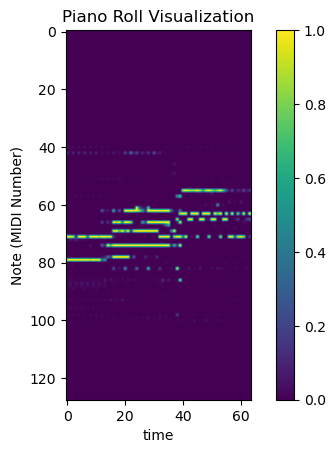

[29/30][0/990]	Loss_D: 0.5277	Loss_G: 3.7900	D(x): 0.8257	D(G(z)): 0.0843 / 0.0559
[29/30][15/990]	Loss_D: 0.6209	Loss_G: 3.2805	D(x): 0.8002	D(G(z)): 0.1118 / 0.0992
[29/30][30/990]	Loss_D: 0.6145	Loss_G: 2.9042	D(x): 0.7268	D(G(z)): 0.0855 / 0.1282
[29/30][45/990]	Loss_D: 0.6146	Loss_G: 2.8847	D(x): 0.7933	D(G(z)): 0.1146 / 0.1258
[29/30][60/990]	Loss_D: 0.5840	Loss_G: 3.2172	D(x): 0.8356	D(G(z)): 0.1271 / 0.1041
[29/30][75/990]	Loss_D: 0.6526	Loss_G: 3.3182	D(x): 0.8126	D(G(z)): 0.1475 / 0.0978
[29/30][90/990]	Loss_D: 0.6382	Loss_G: 3.3088	D(x): 0.7434	D(G(z)): 0.1258 / 0.1084
[29/30][105/990]	Loss_D: 0.6729	Loss_G: 2.6298	D(x): 0.8219	D(G(z)): 0.1779 / 0.1757
[29/30][120/990]	Loss_D: 0.6001	Loss_G: 2.7002	D(x): 0.8680	D(G(z)): 0.1661 / 0.1671
[29/30][135/990]	Loss_D: 0.7653	Loss_G: 3.2165	D(x): 0.7150	D(G(z)): 0.1246 / 0.1098
[29/30][150/990]	Loss_D: 0.6508	Loss_G: 3.1884	D(x): 0.8484	D(G(z)): 0.1582 / 0.1140
[29/30][165/990]	Loss_D: 0.7474	Loss_G: 2.7499	D(x): 0.7845	D(G(z)): 0.15

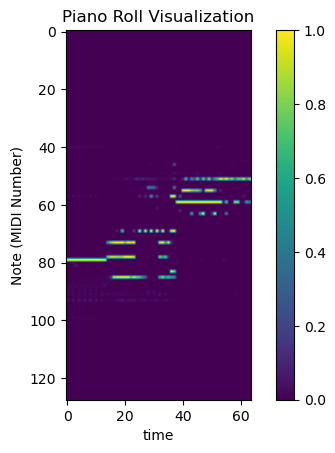

Training finished.


In [61]:
is_train = 1

LR = 0.0002
NZ = 100
N_G_TRAIN = 2
l1 =0.01
l2 = 0.1
EPOCHS = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if is_train ==1:
        
    netG = Generator(nz=NZ)
    netD = Discriminator()

    optimizerG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss()

    D_losses, G_losses = train(netD=netD,
            netG=netG,
            optimizerD=optimizerD,
            optimizerG=optimizerG,
            epochs=EPOCHS,
            criterion=criterion,
            nz=NZ,
            n_g_train=N_G_TRAIN,
            lamda1 = l1,
            lamda2 = l2,
            device=device,
            data_loader=train_loader)

Text(0, 0.5, 'loss')

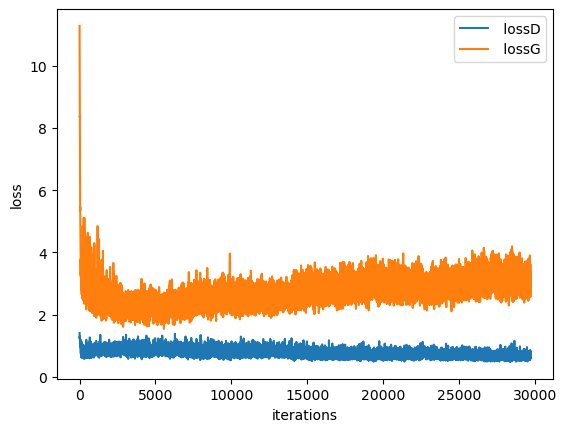

In [62]:
lossD_print = np.load('lossD_list.npy')
lossG_print = np.load('lossG_list.npy')
length = lossG_print.shape[0]
x = np.linspace(0, length-1, length)
x = np.asarray(x)
plt.figure()
plt.plot(x, lossD_print,label=' lossD',linewidth=1.5)
plt.plot(x, lossG_print,label=' lossG',linewidth=1.5)
plt.legend(loc='upper right')
plt.xlabel('iterations')
plt.ylabel('loss')

In [70]:
def sample():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    netG = Generator(nz=NZ)
    netG.load_state_dict(torch.load('netG_parameters.torch'))
    netG.to(device)

    netG.eval()

    random_sample_index = randrange(0, len(train_iter))
    priming_melody = train_iter[random_sample_index][0].unsqueeze(0).to(device)

    outputs = []
    for i in range(0,30):
        noise = torch.randn(1, NZ).to(device)
        if i == 0:
            with torch.no_grad():
                bar = netG(noise,priming_melody)
                #outputs.append(netG(noise,priming_melody))
                print_piano_roll(bar.detach().cpu().numpy().squeeze().transpose())
                outputs.append(bar)
        else:
            with torch.no_grad():

                bin_output = (outputs[i - 1] > 0.6).float()
                bar = netG(noise,bin_output)
                #outputs.append(netG(noise,outputs[i - 1]))
                outputs.append(bar)
                print_piano_roll(bar.detach().cpu().numpy().squeeze().transpose())

    melody = [outputs[i].detach().cpu().numpy().squeeze().transpose() for i in range(len(outputs))]
    melody = np.stack(melody)
    melody = np.concatenate(melody, axis=1)

    return melody



In [64]:
def piano_roll_to_pretty_midi(piano_roll, fs, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.

    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.

    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.

    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

C:\Users\gabro\AppData\Local\Temp\ipykernel_28588\282206596.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('netG_parameters.torch'))


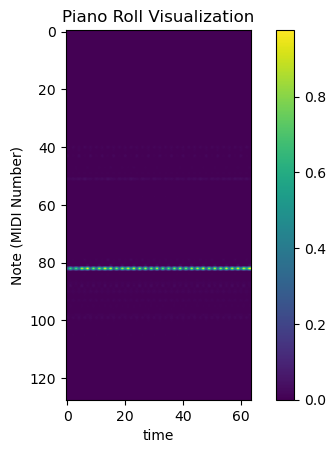

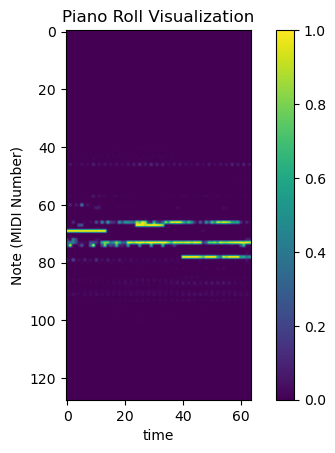

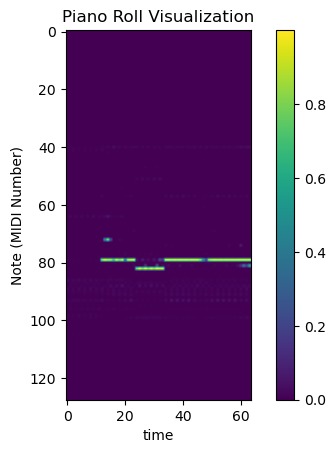

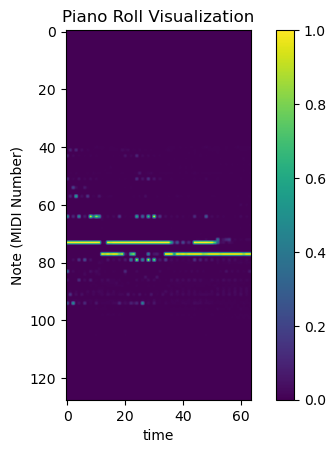

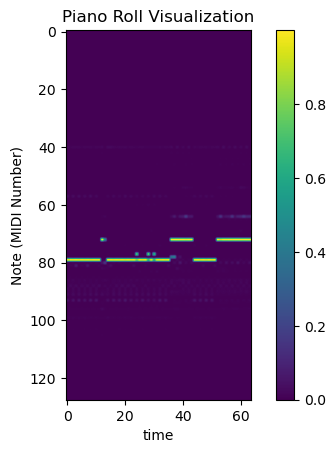

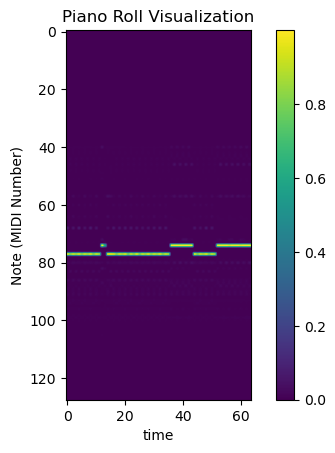

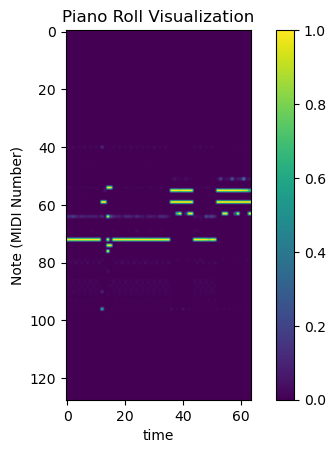

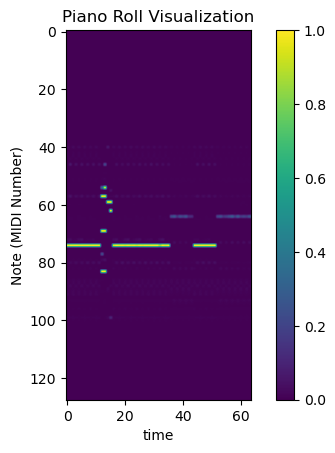

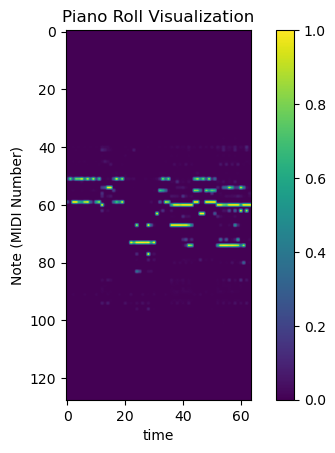

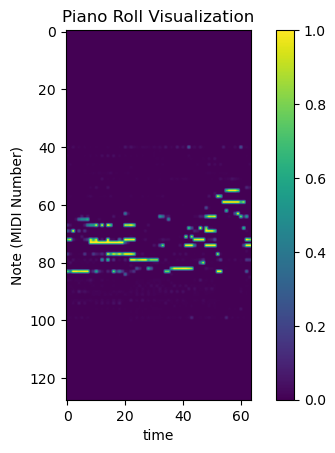

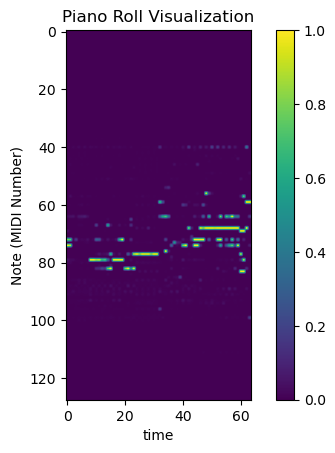

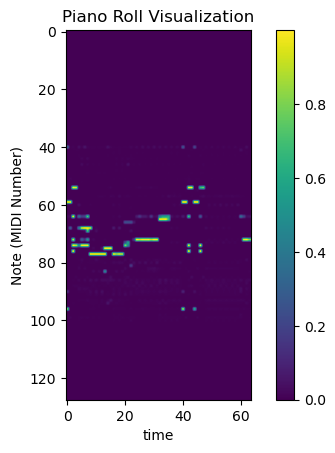

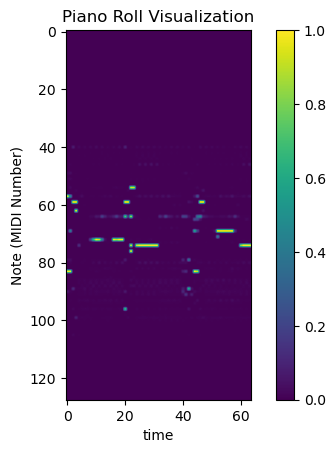

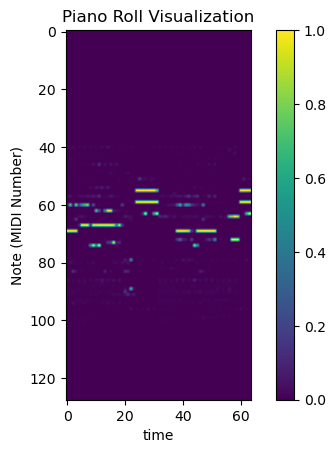

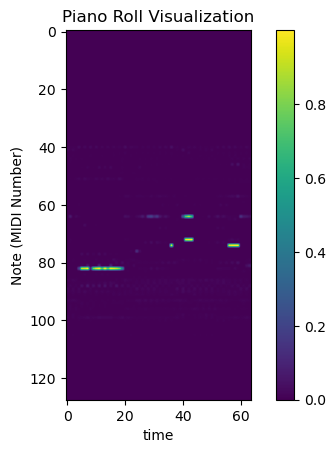

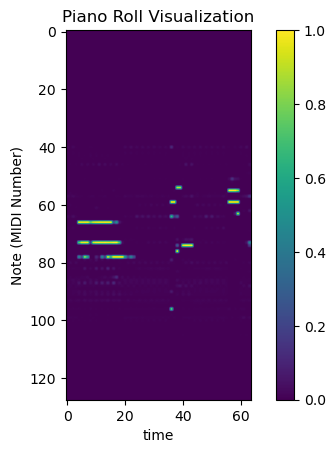

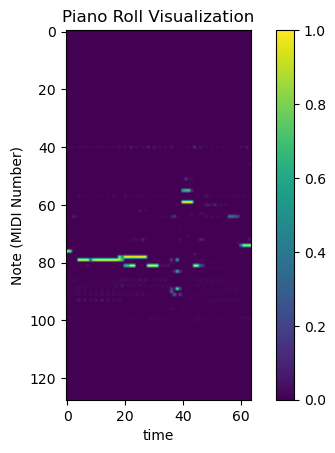

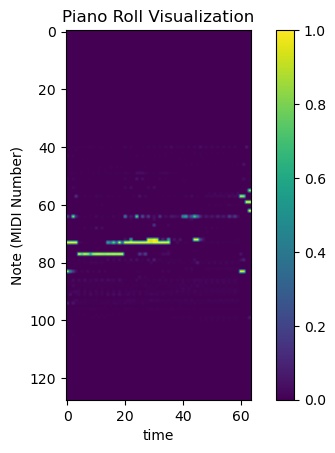

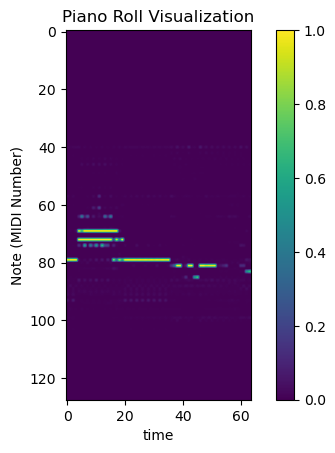

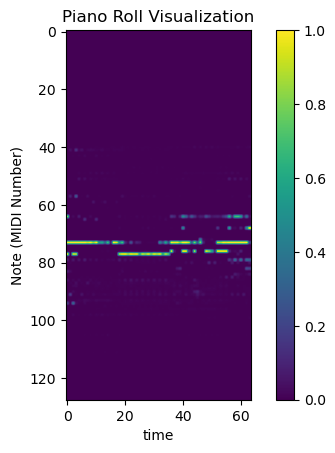

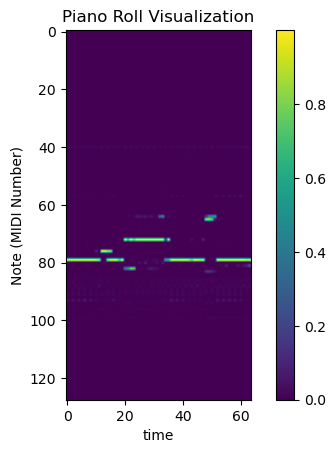

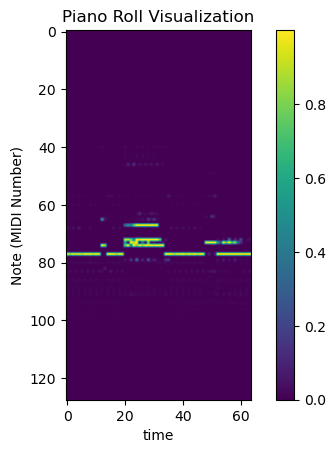

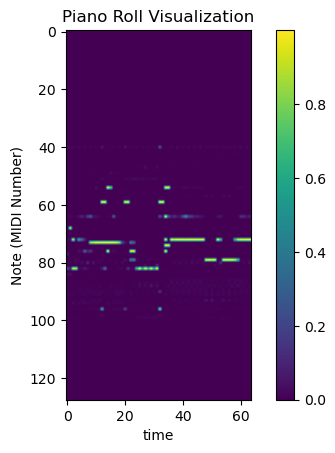

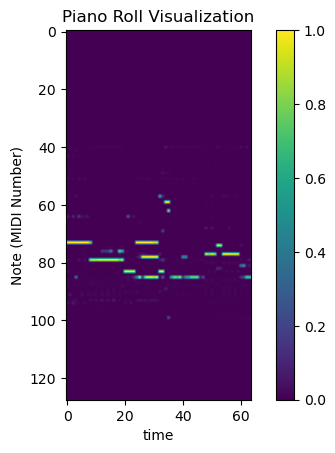

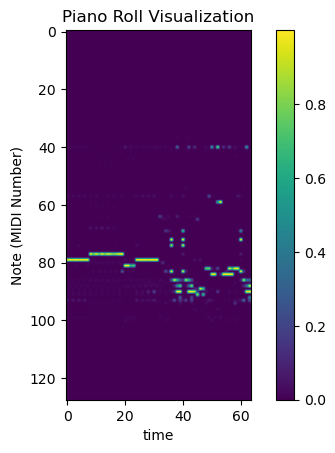

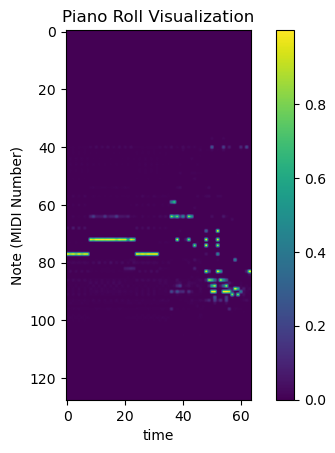

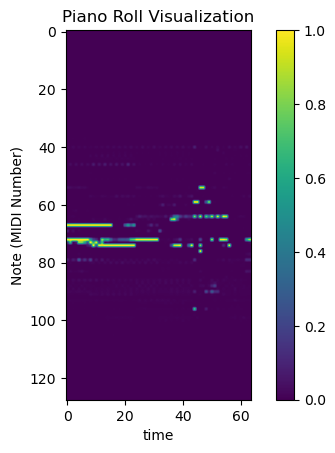

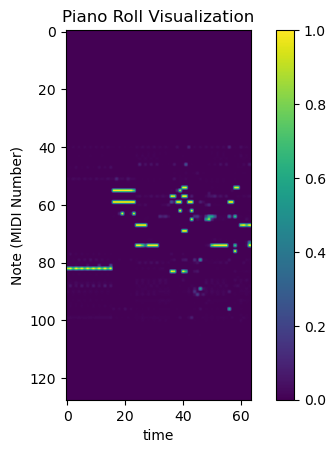

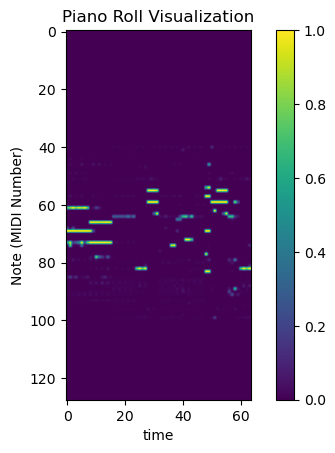

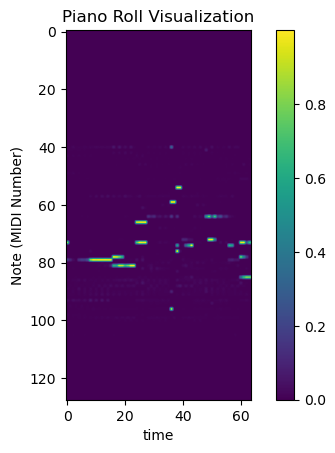

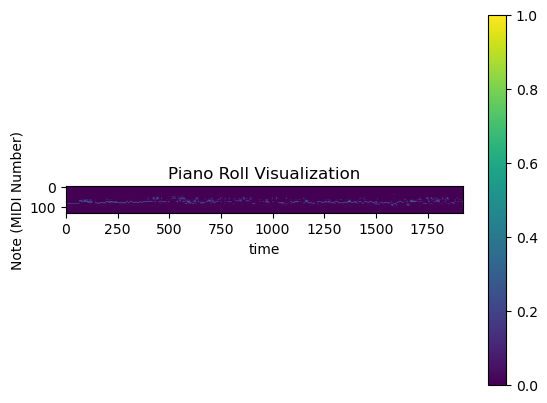

In [78]:
song = sample()

print_piano_roll(song)

song[song > 0.4] = 100

bpm = 190

sixtheen_note_per_sec = (bpm*16)/60
midi = piano_roll_to_pretty_midi(song, fs=sixtheen_note_per_sec, program=0)
midi.write('output.mid')
